#### Notes
- DATASET: Customer-level data of a leading telecom firm, 
    - Data spans over four consecutive months - June, July, August and September. 
    - First 2 months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.
- GOAL: Identify customers at high risk of churn and identify the main indicators of churn.
- Business objective: Predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In this project 
- it is primarliy Indian and Southeast Asian market.
- the usage-based definition is used to define churn.
- High-value customers are defined - who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase) = 29.9k rows
- Predict churn only on high-value customers.

### Strategy followed for analysis & model building
| | Step |  Status| Notes |
|---|---|---|---|
|1. | Read & filter data |  | |
|| &emsp;Filter high-value customers | Done | Do we use >= 70% or > 70% ? |
|| &emsp;Tag churners | Done | |
|2. | Pre-process data | | |
|| &emsp;Handle invalid & missing values | Done | |
|| &emsp;Explore data | In progress | |
|| &emsp;Remove attributes of the churn phase | Done | |
|| &emsp;Impute Missing value | Done | |
|| &emsp;Derive new features | In Progress | |
|| &emsp;Handle Outliers | Todo | |
|| &emsp;Create Dummy variables | Todo | |
|3. | Prepare Data for model building | | |
|| &emsp;Test train split | | |
|| &emsp;Standardise numerical values | | |
|| &emsp;Perform Dimensionality reduction (PCA) | | |
|4.| Build model to predict customers who will churn  - with PCA | | Train a variety of models |
|| &emsp;Build model and evaluate | | |
|| &emsp;Use Regularization | | |
|| &emsp;Model evaluation | | |
|| &emsp;Interpretation of the model | | |
|5.| Build model to identify indicators of churn  - w/o PCA | | Logistic regression or a model from the tree family |
|| &emsp;Build model and evaluate | | |
|| &emsp;Use Regularization | | |
|| &emsp;Model evaluation | | |
|| &emsp;Interpretation of the model | | |
|6.| Recommend strategies to manage customer churn | | |
|| &emsp;| | |
|| | | |

#### Hints
- Using techniques to handle class imbalance - stratify
- In case of logistic regression, make sure to handle multi-collinearity.

### Imports & Functions

In [1]:
import sys

import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

# For data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Calculates and returns the percentage of a value in the total
def percent(value, total):
    return round(100 * value/total, 2)  

# Display the len and columns of the df
def listColumns(df):
    print(f"{len(df.columns.tolist())} {df.columns.tolist()}")

# Get the columns with the specified prefix
def getColumnsWithPrefix(prefix, cols):
    lenPrefix = len(prefix)
    l =list(filter(lambda x: True if x[:lenPrefix]==prefix else False,cols))
    print(len(l), l)
    return l

# Get the columns with the specified suffix
def getColumnsWithSuffix(suffix,cols):
    lenSuffix = len(suffix)
    l =list(filter(lambda x: True if x[-1 * lenSuffix:]==suffix else False,cols))
    print(len(l), l)
    return l

def dropColumns(df_, coldesc, cols):
    print(f"Drop {coldesc} {len(cols)} columns: Shape {df_.shape}", end='')
    df_.drop(columns = cols, inplace=True)
    df_.reset_index(drop=True, inplace=True)
    print(f" --> {df_.shape}")

def dropRows(df_, indesc, index):
    print(f"Drop {indesc} {len(index)} Rows: Shape {df_.shape}", end='')
    df_.drop(index, inplace=True)
    df_.reset_index(drop=True, inplace=True)
    print(f" --> {df_.shape}")

# Get the number and percent of duplicate rows in the column
def getDuplicateRows(df, col):
    duplcate_rows = df[df[col].duplicated()][col].shape[0]
    return duplcate_rows, percent(duplcate_rows, df.shape[0])
    
# Lists the columns with missing values - col name, absolute number and percentage of cells missing in the column. 
# The columns are sorted in descending order of the number of missing values.
def listColumsWithMissingData(df, LIMIT=0):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    cols = {}
    for col in df.columns:
        if df[col].isna().any():
            missing_count = df[col].isna().sum(),percent(df[col].isna().sum(),df.shape[0])
            #print(col, missing_count)
            if missing_count[1] < LIMIT: continue
            cols[col] = missing_count
    cols = sorted(cols.items(), key=lambda x: x[1][0], reverse=True)
    #[print(f"{col[0]:15}  {col[1][0]:7d} {col[1][1]}%") for col in cols ]
    return cols

# Displays the columns with missing data using msno matrix and bar
def displayColumnsWithMissingData(df_):
    plt.figure(figsize=(10, 6 ))
    msno.matrix(df_[df_.columns[df_.isnull().any()]]);plt.show()
    msno.bar(df_[df_.columns[df_.isnull().any()]]);plt.show()

# Gets the list of columns which are categorical in nature
def getCategoricalColumns(df):
    cat_columns_ = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns = sorted(cat_columns_)
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    return cat_columns_

# For each categorical column, 
# - prints all the unique values 
# - plots the distribution of values
def plotCategoricalVariables(df_, cat_columns, title):
    COLS = 4
    count = len(cat_columns)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = cat_columns[i]
        count_values = df_[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df_[col].unique().tolist())) if np.NaN not in df_[col].unique().tolist() else (df_[col].unique().tolist())}")
        df__ = (df_[[col]].value_counts(normalize=True)*100)#.to_frame()
        #df__.reset_index(drop=True, inplace=True)
        #df__[col] = df__[col].astype(int)
        #print(df__.head())
        plt.subplot(rows, COLS, i+1);ax=df__.plot.bar();_ = plt.xticks(rotation=0); annotate(ax)
    fig.suptitle(title, fontsize=14)

# Gets the list of columns which are numerical in nature
def getNumericalColumns(df):
    num_columns_ = df.select_dtypes(include=[np.float, np.int64]).columns.tolist()
    num_columns_ = sorted(num_columns_)
    print(f"Columns with numerical values {len(num_columns_)} --> {num_columns_}")
    return num_columns_ 

# For each numerical column, 
# - prints all the unique values (if <30), else prints 10 values
# - plots the distribution of values - distplot (for columns with >30 unique values) or histplot (for columns with <30 unique values)
def plotNumericalVariables(df_, num_cols, title):
    COLS = 4
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        count_values = df_[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.distplot(df_[col])
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 
            #ax=df[col].plot.hist(weights=np.ones(df.shape[0]) / df.shape[0]);annotate(ax, title=col);plt.show()
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.histplot(data=df_[col])

    fig.suptitle(title, fontsize=14)

# Plot the box plots for the specified numerical columns
def plotBoxPlots(df_, num_cols):
    COLS = 6
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        plt.subplot(rows, COLS, i+1);sns.boxplot(y=df_[col])

    fig.suptitle("", fontsize=14)

# Converts the category to a ordinal numerical label
def clategoryToOridnalLabel(X, cat):
    oe = preprocessing.OrdinalEncoder(categories=cat)
    oe.fit(X)
    print(oe.categories_)
    X1 = oe.transform(X)
    #print(X1[:5])
    return X1
    #print(oe.feature_names_in_)

# Creates dummies for categorical columns and returns the combined dataframe
# The categorical column should be dropped.
def addDummies(df, col, dropcat, df_out):
    print(f"[{col}] Before: {df_out.columns.shape[0]}", end=' ')
    temp = pd.get_dummies(df[col], prefix=col, drop_first=True)
    #df.drop(columns=[col], inplace=True)
    #temp = temp.drop([dropcat], 1)
    #Adding the results to the master dataframe
    df_out = pd.concat([df_out, temp], axis=1)
    print(f"After: {df_out.columns.shape[0]}", end=' ')
    print()
    return df_out

# Annotates the bars
def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

# Read & Filter data

In [3]:
df = pd.read_csv("telecom_churn_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [5]:
listColumns(df)

226 ['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m

Do we need to handle missing values for 
- PCA?
- decision trees/random forest? 

In [6]:
COLS= df.columns.tolist()
COLS_ID = ['mobile_number']
COLS_LOC = getColumnsWithPrefix('loc',COLS) # LOCAL
COLS_STD = getColumnsWithPrefix('std',COLS)
COLS_ISD = getColumnsWithPrefix('isd',COLS)
COLS_LAST_DATE = getColumnsWithPrefix('last_date_',COLS)
COLS_DATE = getColumnsWithPrefix('date_',COLS)
COLS_ARPU = getColumnsWithPrefix('arpu',COLS)
COLS_ONNET = getColumnsWithPrefix('onnet',COLS)
COLS_OFFNET = getColumnsWithPrefix('offnet',COLS)
COLS_ROAM = getColumnsWithPrefix('roam',COLS)
COLS_SPL = getColumnsWithPrefix('spl',COLS)
COLS_OG = getColumnsWithPrefix('og',COLS)
COLS_IC = getColumnsWithPrefix('ic',COLS)
COLS_TOTAL = getColumnsWithPrefix('total',COLS)
COLS_MAX = getColumnsWithPrefix('max',COLS)
COLS_COUNT = getColumnsWithPrefix('count',COLS)
COLS_AV = getColumnsWithPrefix('av',COLS)
COLS_VOL = getColumnsWithPrefix('vol',COLS)
COLS_NIGHT = getColumnsWithPrefix('night',COLS)
COLS_MONTH = getColumnsWithPrefix('monthly',COLS)
COLS_SACHET = getColumnsWithPrefix('sachet',COLS)
COLS_FB = getColumnsWithPrefix('fb_user',COLS)
COLS_4_MON = getColumnsWithPrefix('jun',COLS) + getColumnsWithPrefix('jul',COLS) + getColumnsWithPrefix('aug',COLS) + getColumnsWithPrefix('sep',COLS)

38 ['loc_og_t2o_mou', 'loc_ic_t2o_mou', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']
41 ['std_og_t2o_mou', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_t2

In [7]:
df[COLS_LAST_DATE].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014


In [8]:
df[COLS_DATE].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [9]:
COLS_CAT = getCategoricalColumns(df)

Columns with categorical values 12 --> ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']


In [10]:
df[COLS_CAT].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [11]:
COLS_NUM = getNumericalColumns(df)

Columns with numerical values 214 --> ['aon', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'aug_vbc_3g', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'circle_id', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'ic_others_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_ic_mou_9', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_og_mou_9', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'lo

## Filter high value customers

```High-value customers``` are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After filtering the high-value customers, you should get about 29.9k rows.

In [12]:
print(list(filter(lambda x: True if 'rech_amt' in x else False, COLS)))

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [13]:
# The average recharge amount in the good phase (months 6 & 7) is in the columns 'total_rech_amt_6', 'total_rech_amt_7'. Check if there is missing data
df[['total_rech_amt_6', 'total_rech_amt_7']].isnull().sum()

total_rech_amt_6    0
total_rech_amt_7    0
dtype: int64

The  columns 'total_rech_amt_6', 'total_rech_amt_7' do not have any missing data. So we can proceed to calculate the high-value customers

In [14]:
# Store the average recharge amount in the good phase (months 6 & 7) in the column 'avg_rech_amt_67'
df['avg_rech_amt_67'] = (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2
print("Average recharge amount:");print(df[['total_rech_amt_6', 'total_rech_amt_7', 'avg_rech_amt_67']].head())

# Calculate the 70th percentile of the average recharge amount in the good phase (months 6 & 7)
PC_70_AVG_RECH_AMT = df['avg_rech_amt_67'].quantile([.7]).values[0]; print('\nPC_70_AVG_RECH_AMT:', PC_70_AVG_RECH_AMT)

# Drop all the rows with avg_rech_amt_67 below 70th percentile. Retain only the high value customers
print("Number of rows > PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>PC_70_AVG_RECH_AMT].shape[0])
print("Number of rows >= PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>=PC_70_AVG_RECH_AMT].shape[0])
df = df[df['avg_rech_amt_67']>PC_70_AVG_RECH_AMT]
print("Number of rows retained in df:", df.shape[0])

Average recharge amount:
   total_rech_amt_6  total_rech_amt_7  avg_rech_amt_67
0               362               252            307.0
1                74               384            229.0
2               168               315            241.5
3               230               310            270.0
4               196               350            273.0

PC_70_AVG_RECH_AMT: 368.5
Number of rows > PC_70_AVG_RECH_AMT: 29979
Number of rows >= PC_70_AVG_RECH_AMT: 30011
Number of rows retained in df: 29979


In [15]:
df.shape

(29979, 227)

## Tag the churners

Step1: Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

Step2: After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [16]:
COLS_USAGE = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
print(df[COLS_USAGE].shape[0])
print(df[COLS_USAGE].isnull().sum())

29979
total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64


None of the columns needed to tag having data. So we can proceed without further processing

In [17]:
# Find the number of rows where each of the columns are 0
df[df['total_ic_mou_9']==0].shape[0], df[df['total_og_mou_9']==0].shape[0],df[df['vol_2g_mb_9']==0].shape[0], df[df['vol_3g_mb_9']==0].shape[0]

(2937, 3245, 20678, 22801)

In [18]:
# Find all the rows where the churn columns are 0 - no calls & no mobile internet usage
CHURN_CONDITION = (df['total_ic_mou_9']==0) & (df['total_og_mou_9']==0) & (df['vol_2g_mb_9']==0) & (df['vol_3g_mb_9']==0)
df[CHURN_CONDITION].shape[0]

2589

In [19]:
# Tag the customers with all churn columns 0 - no calls & no mobile internet usage
COL_TARGET = 'churn'
print("Columns:", len(df.columns.tolist()), end=' --> ')
df[COL_TARGET] = 0
df.loc[CHURN_CONDITION, 'churn'] = 1

Columns: 227 --> 

NOTE: We will do the step2 (remove the columns of month 9) after exploring how the customer behaviour is across various phases

In [20]:
print(len(df.columns.tolist())); print((100*df[COL_TARGET].value_counts(normalize=True)).round(2))

228
0    91.36
1     8.64
Name: churn, dtype: float64


The target variable ```churn``` is imbalanced with 91% no churn and 9% churn data points.

|   | | Predicted|  |
|---|---|---|---|
||   | 0  | 1  |
| Actual | 0 | TN   | FP  |
| | 1 |  FN |  TP |

- **False Positive (FP)**: Predicted "Churn" but was "No Churn"
- **False Negative (FN)**: Predicted "No Churn" but was "Churn" --> We would like this to be as low as possible because lot of genuine high value customers who could churn will not be addressed 

So, the evaluation metric for the classification models would be **Recall**=TP/(TP+FN)


In [21]:
df.shape

(29979, 228)

# Pre-process Data

## Handle invalid & missing values

### Identify columns with missing data

<Figure size 720x432 with 0 Axes>

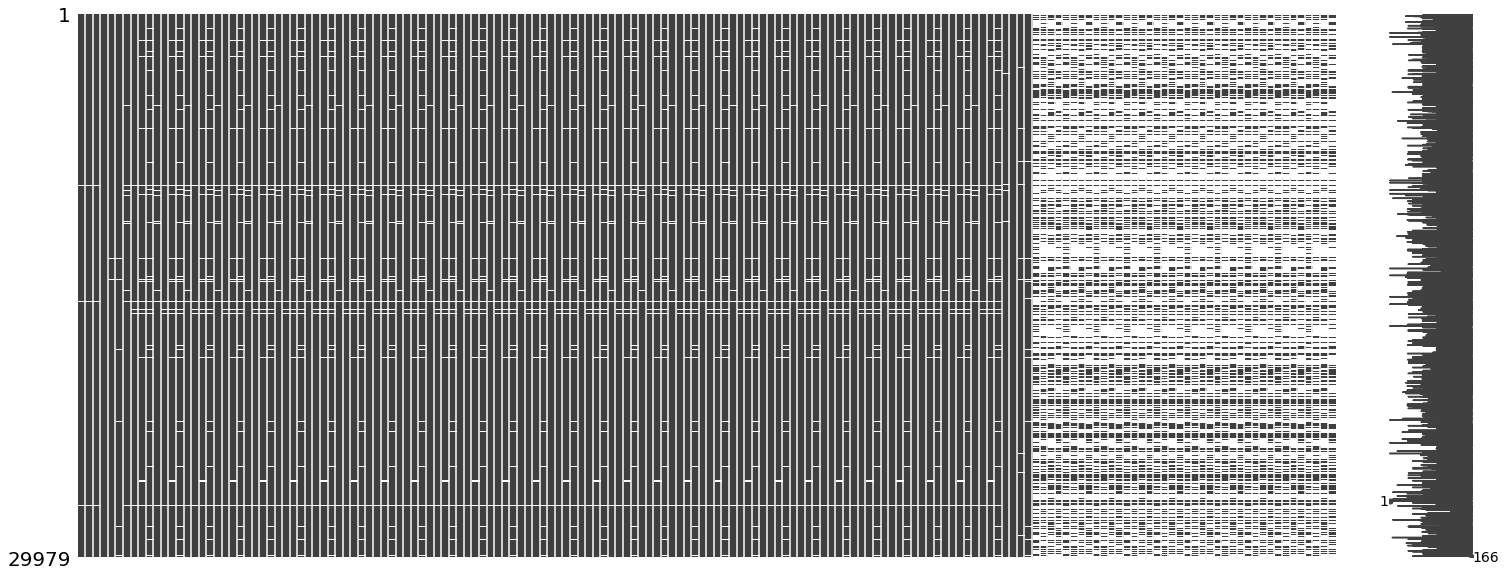

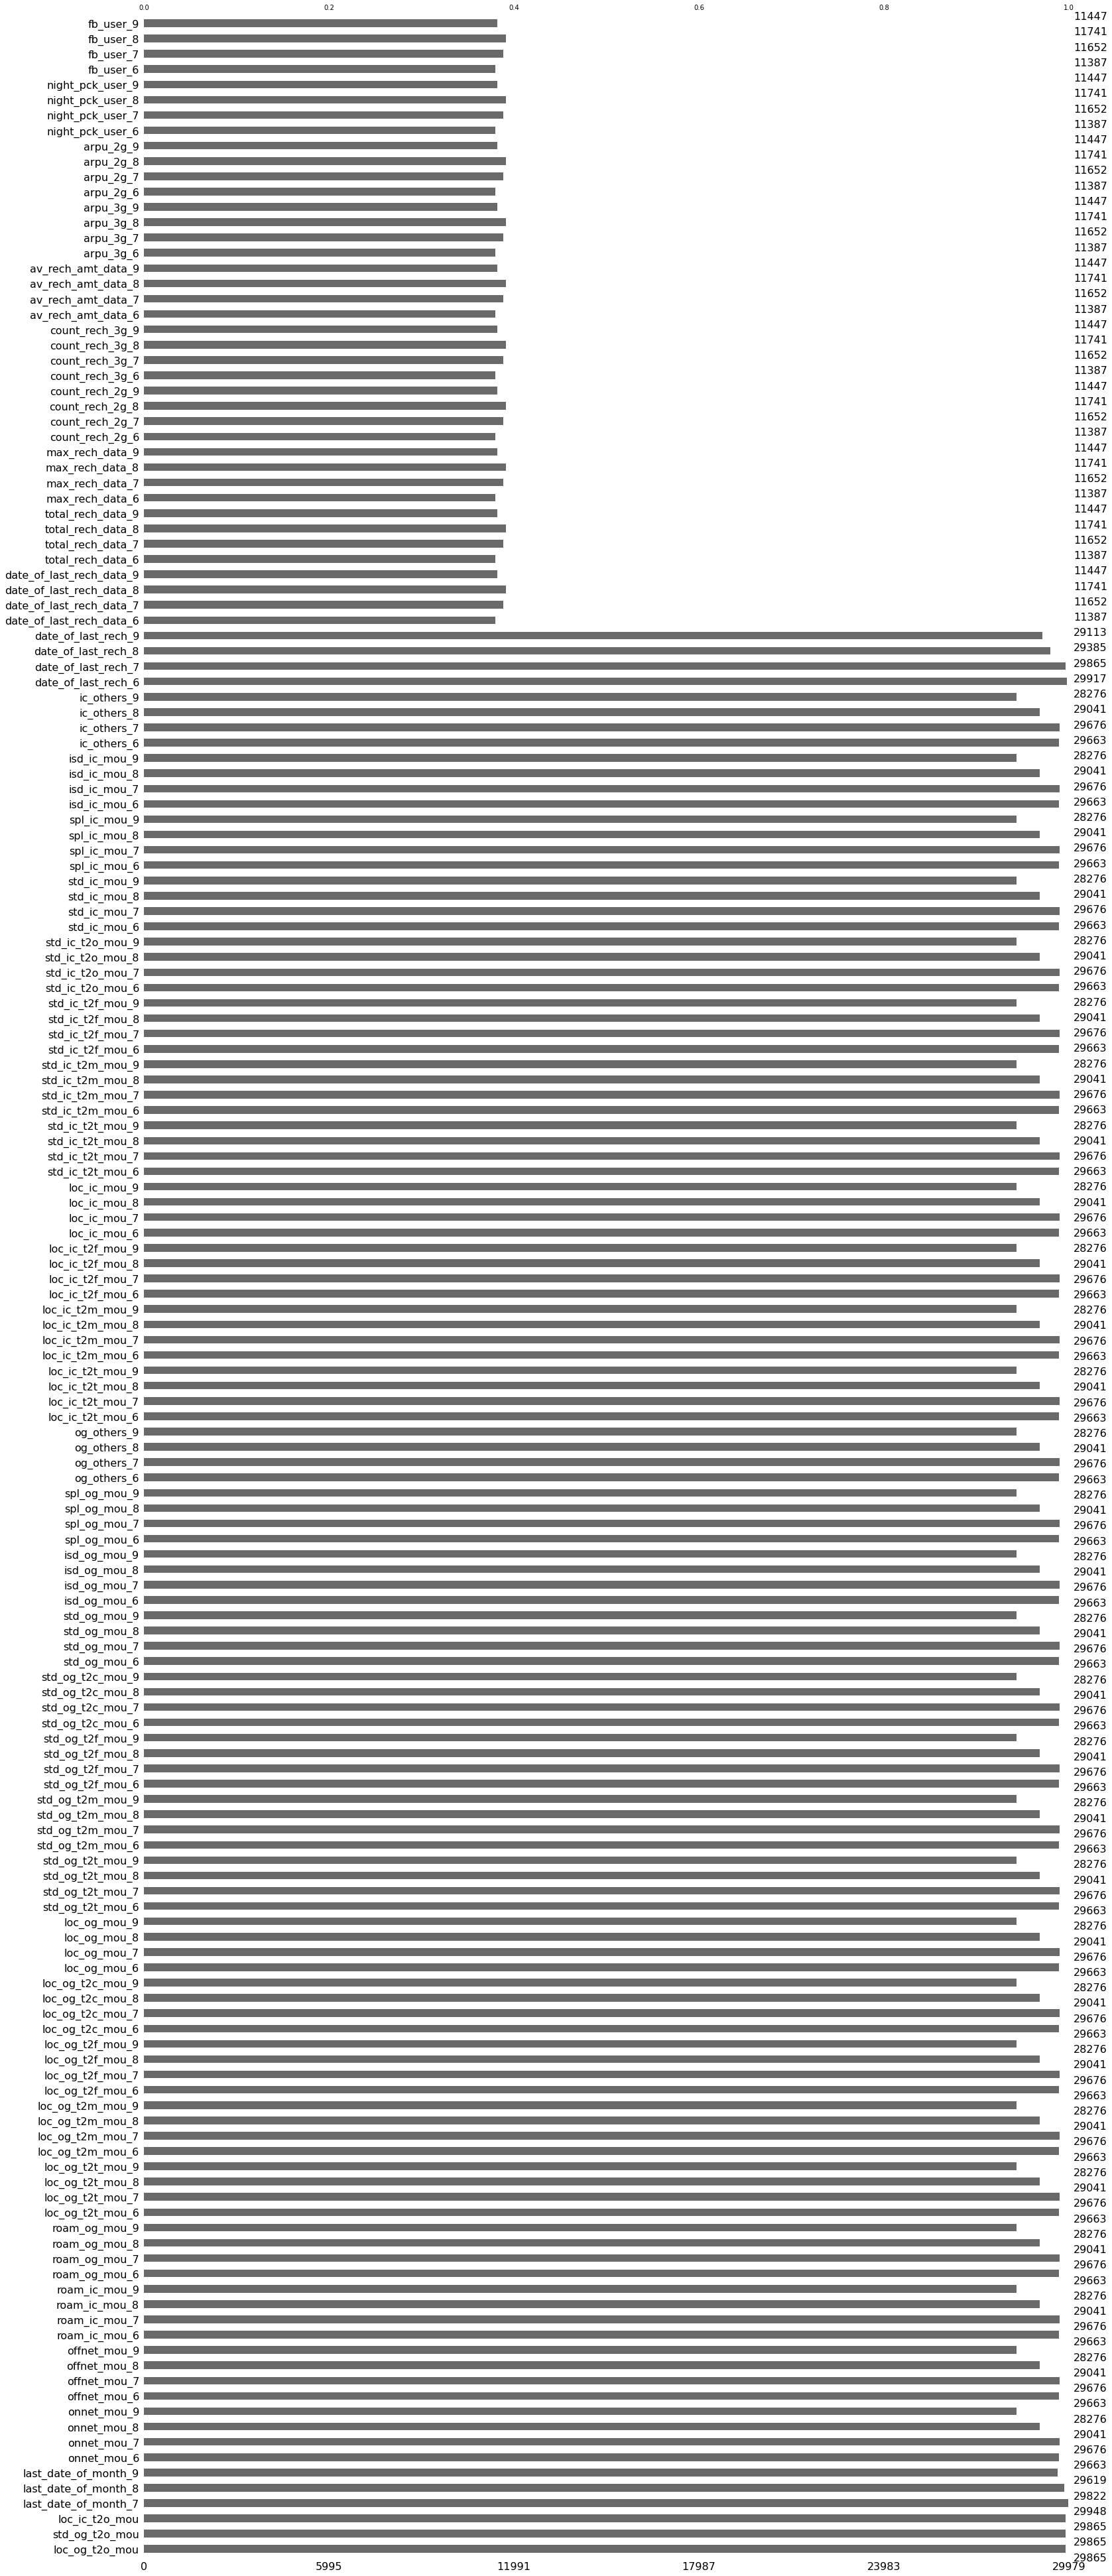

Columns with missing data: 166 72.81%


[('date_of_last_rech_data_6', (18592, 62.02)),
 ('total_rech_data_6', (18592, 62.02)),
 ('max_rech_data_6', (18592, 62.02)),
 ('count_rech_2g_6', (18592, 62.02)),
 ('count_rech_3g_6', (18592, 62.02)),
 ('av_rech_amt_data_6', (18592, 62.02)),
 ('arpu_3g_6', (18592, 62.02)),
 ('arpu_2g_6', (18592, 62.02)),
 ('night_pck_user_6', (18592, 62.02)),
 ('fb_user_6', (18592, 62.02)),
 ('date_of_last_rech_data_9', (18532, 61.82)),
 ('total_rech_data_9', (18532, 61.82)),
 ('max_rech_data_9', (18532, 61.82)),
 ('count_rech_2g_9', (18532, 61.82)),
 ('count_rech_3g_9', (18532, 61.82)),
 ('av_rech_amt_data_9', (18532, 61.82)),
 ('arpu_3g_9', (18532, 61.82)),
 ('arpu_2g_9', (18532, 61.82)),
 ('night_pck_user_9', (18532, 61.82)),
 ('fb_user_9', (18532, 61.82)),
 ('date_of_last_rech_data_7', (18327, 61.13)),
 ('total_rech_data_7', (18327, 61.13)),
 ('max_rech_data_7', (18327, 61.13)),
 ('count_rech_2g_7', (18327, 61.13)),
 ('count_rech_3g_7', (18327, 61.13)),
 ('av_rech_amt_data_7', (18327, 61.13)),
 ('a

In [22]:
displayColumnsWithMissingData(df)
listColumsWithMissingData(df)

In [23]:
cols_miss_ = listColumsWithMissingData(df, 40)
cols_miss = [col[0] for col in cols_miss_]
print("Columns with more than 40% missing data:", cols_miss)#;[print(col, end=', ') for col in COLS_MISS]; print()

Columns with missing data: 166 72.81%
Columns with more than 40% missing data: ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9', 'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7', 'date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8']


We should drop all these columns. Let's add the columns to drop to COLS_TO_DROP

In [24]:
COLS_TO_DROP = cols_miss

### Identify columns of Id type and with all same value

In [25]:
for col in COLS_CAT:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

last_date_of_month_6: Duplicates 29978, 100.0 Unique values: 1
last_date_of_month_7: Duplicates 29977, 99.99 Unique values: 1
last_date_of_month_8: Duplicates 29977, 99.99 Unique values: 1
last_date_of_month_9: Duplicates 29977, 99.99 Unique values: 1
date_of_last_rech_6: Duplicates 29948, 99.9 Unique values: 30
date_of_last_rech_7: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_8: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_9: Duplicates 29948, 99.9 Unique values: 30
date_of_last_rech_data_6: Duplicates 29948, 99.9 Unique values: 30
date_of_last_rech_data_7: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_data_8: Duplicates 29947, 99.89 Unique values: 31
date_of_last_rech_data_9: Duplicates 29948, 99.9 Unique values: 30


In [26]:
print("Duplicates in mobile_number:", getDuplicateRows(df, 'mobile_number'))
print("Duplicates in circle_id:", getDuplicateRows(df, 'circle_id'))

Duplicates in mobile_number: (0, 0.0)
Duplicates in circle_id: (29978, 100.0)


In [27]:
cols_all_same_value = []
cols_less_unique_values = []
cols_all_unique = []
for col in COLS:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    unique_values = df[col].value_counts().index.tolist()
    unique_rows_num = len(unique_values) #df[col].value_counts(normalize=True).shape[0]
    if unique_rows_num == 1:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} ")
        cols_all_same_value.append(col)
    elif duplicate_rows_num == 0:
        cols_all_unique.append(col)
    elif unique_rows_num < 3:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} {unique_values}")
        cols_less_unique_values.append(col)
    #print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

print();print('COLS_ALL_UNIQUE', cols_all_unique)
print('COLS_ALL_SAME_VALUE', cols_all_same_value)
print('COLS_LESS_UNIQUE_VALUES', cols_less_unique_values)

circle_id: Duplicates 29978, 100.0 Unique values: 1 
loc_og_t2o_mou: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2o_mou: Duplicates 29977, 99.99 Unique values: 1 
loc_ic_t2o_mou: Duplicates 29977, 99.99 Unique values: 1 
last_date_of_month_6: Duplicates 29978, 100.0 Unique values: 1 
last_date_of_month_7: Duplicates 29977, 99.99 Unique values: 1 
last_date_of_month_8: Duplicates 29977, 99.99 Unique values: 1 
last_date_of_month_9: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_6: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_7: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_8: Duplicates 29977, 99.99 Unique values: 1 
std_og_t2c_mou_9: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_6: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_7: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_8: Duplicates 29977, 99.99 Unique values: 1 
std_ic_t2o_mou_9: Duplicates 29977, 99.99 Unique values: 1 
night_pck_user_6: Duplicates 29976, 9

- Mobile number is unique for all rows. This should be dropped for model building.
- As all the rows for the COLS_ALL_SAME_VALUE columns have the same value. We can drop these.
Let's append these to the COLS_TO_DROP

In [28]:
print("Before: ", len(COLS_TO_DROP), COLS_TO_DROP)
COLS_TO_DROP.extend(cols_all_same_value)
COLS_TO_DROP.extend(cols_all_unique)
print();print("After: ", len(COLS_TO_DROP), COLS_TO_DROP)

Before:  40 ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9', 'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7', 'date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8']

After:  57 ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech

### Handle Missing data

Drop the columns in COLS_TO_DROP - columns with 
- > 40% missing data
- all same data
- all unique data

In [29]:
dropColumns(df, "COLS_TO_DROP", COLS_TO_DROP)

Drop COLS_TO_DROP 57 columns: Shape (29979, 228) --> (29979, 171)


Drop rows with > 80% missing data

In [30]:
df_row_gt_80_miss = df[df.isna().sum(axis="columns") > 80]
df_row_gt_80_miss.shape[0], 100 * df_row_gt_80_miss.shape[0]/df.shape[0]

(254, 0.8472597484906101)

There are 254 rows i.e. <1% rows with > 80% data missing. Let's drop this

In [31]:
dropRows(df, "ROWS > 80", df_row_gt_80_miss.index)

Drop ROWS > 80 254 Rows: Shape (29979, 171) --> (29725, 171)


<Figure size 720x432 with 0 Axes>

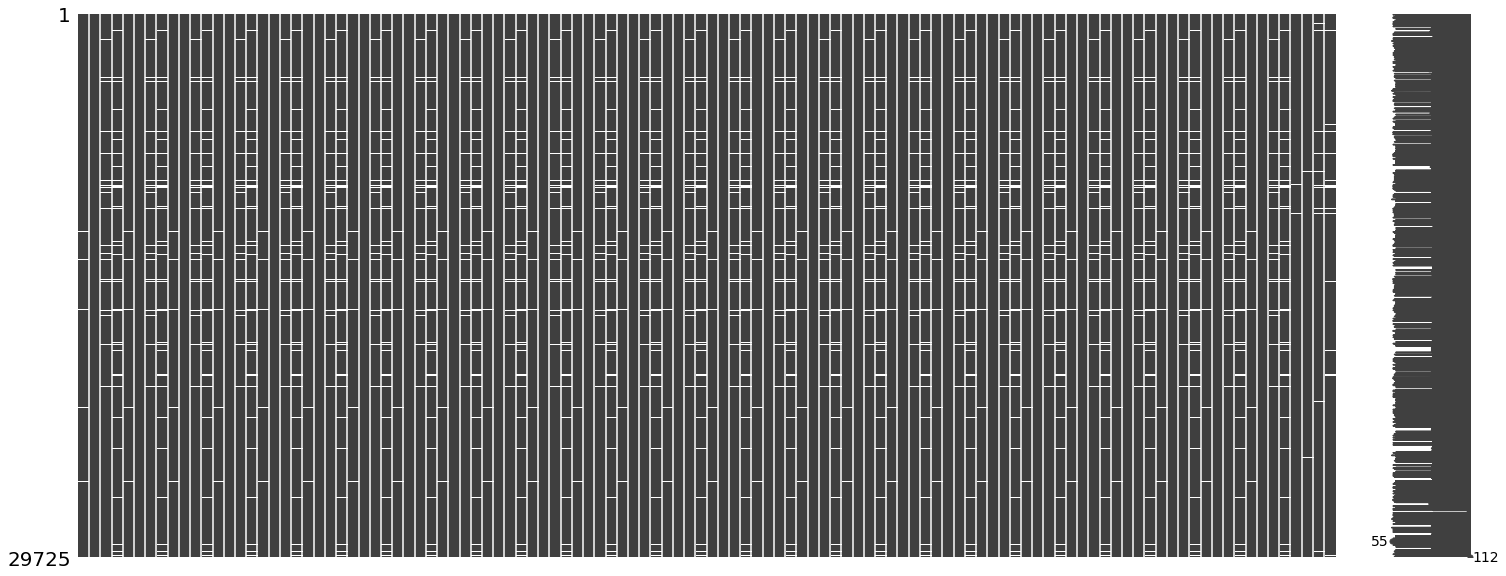

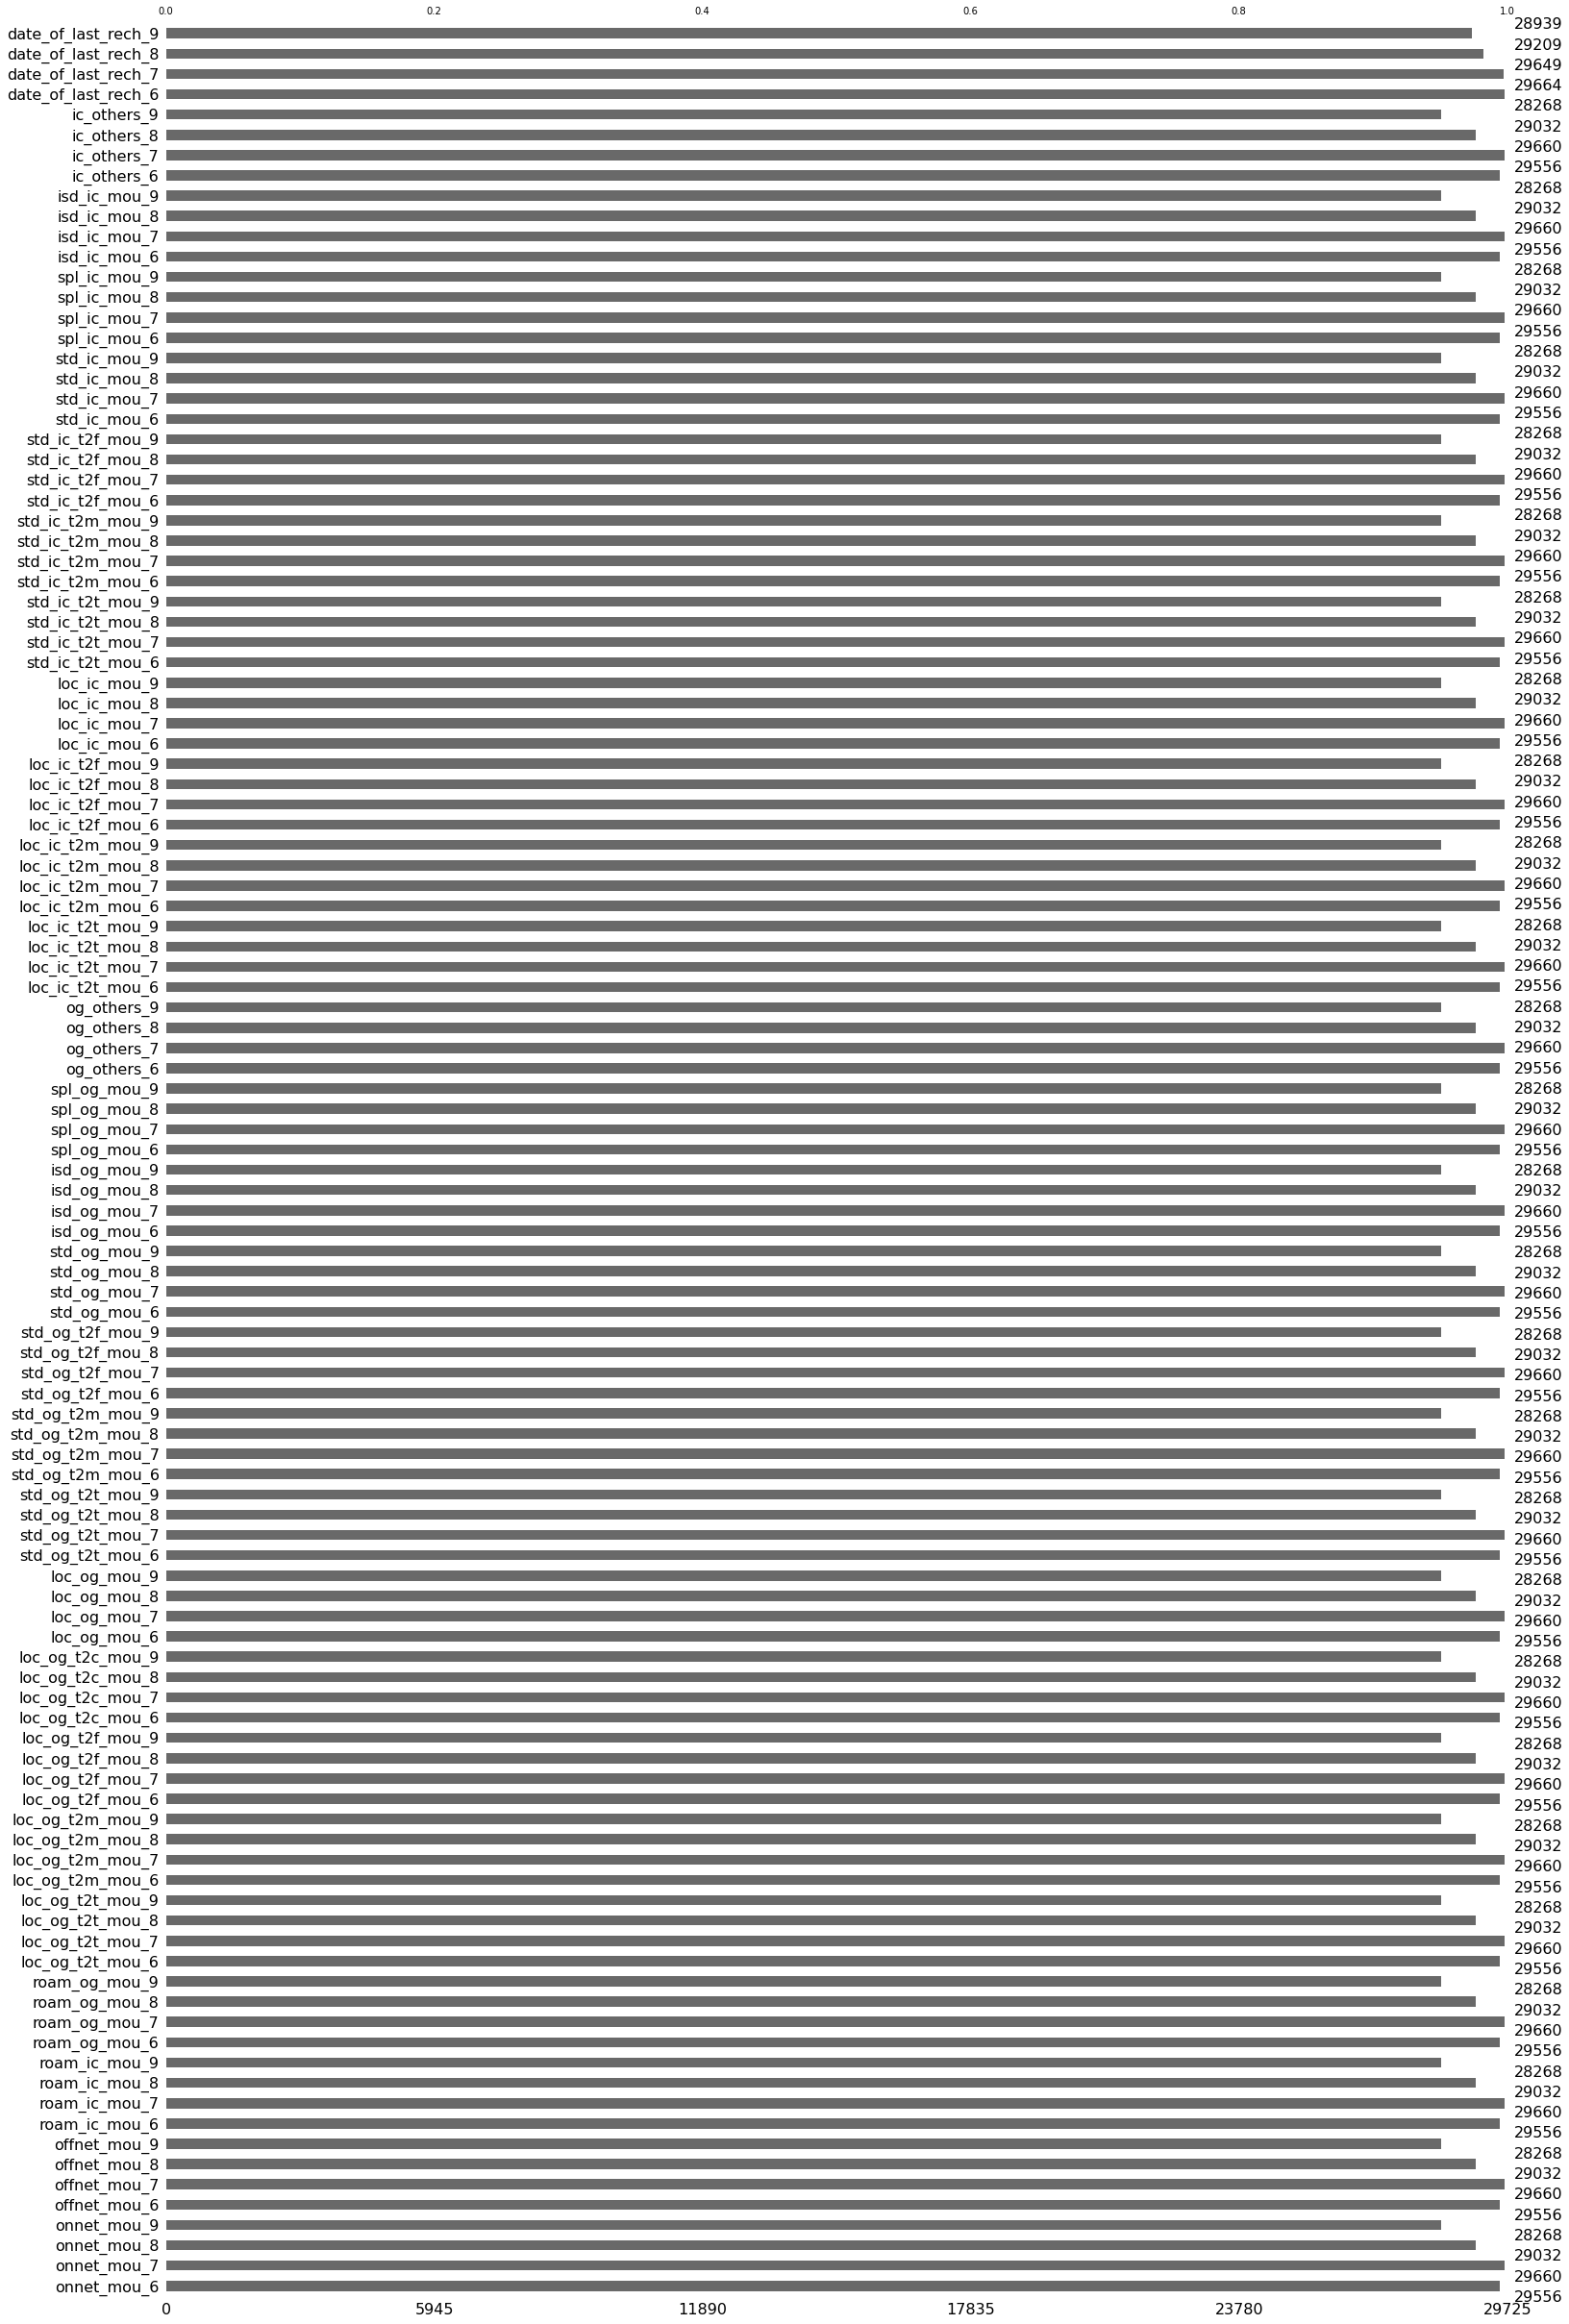

Columns with missing data: 112 65.5%
onnet_mou_9, offnet_mou_9, roam_ic_mou_9, roam_og_mou_9, loc_og_t2t_mou_9, loc_og_t2m_mou_9, loc_og_t2f_mou_9, loc_og_t2c_mou_9, loc_og_mou_9, std_og_t2t_mou_9, std_og_t2m_mou_9, std_og_t2f_mou_9, std_og_mou_9, isd_og_mou_9, spl_og_mou_9, og_others_9, loc_ic_t2t_mou_9, loc_ic_t2m_mou_9, loc_ic_t2f_mou_9, loc_ic_mou_9, std_ic_t2t_mou_9, std_ic_t2m_mou_9, std_ic_t2f_mou_9, std_ic_mou_9, spl_ic_mou_9, isd_ic_mou_9, ic_others_9, date_of_last_rech_9, onnet_mou_8, offnet_mou_8, roam_ic_mou_8, roam_og_mou_8, loc_og_t2t_mou_8, loc_og_t2m_mou_8, loc_og_t2f_mou_8, loc_og_t2c_mou_8, loc_og_mou_8, std_og_t2t_mou_8, std_og_t2m_mou_8, std_og_t2f_mou_8, std_og_mou_8, isd_og_mou_8, spl_og_mou_8, og_others_8, loc_ic_t2t_mou_8, loc_ic_t2m_mou_8, loc_ic_t2f_mou_8, loc_ic_mou_8, std_ic_t2t_mou_8, std_ic_t2m_mou_8, std_ic_t2f_mou_8, std_ic_mou_8, spl_ic_mou_8, isd_ic_mou_8, ic_others_8, date_of_last_rech_8, onnet_mou_6, offnet_mou_6, roam_ic_mou_6, roam_og_mou_6, loc_og

[('onnet_mou_9', (1457, 4.9)),
 ('offnet_mou_9', (1457, 4.9)),
 ('roam_ic_mou_9', (1457, 4.9)),
 ('roam_og_mou_9', (1457, 4.9)),
 ('loc_og_t2t_mou_9', (1457, 4.9)),
 ('loc_og_t2m_mou_9', (1457, 4.9)),
 ('loc_og_t2f_mou_9', (1457, 4.9)),
 ('loc_og_t2c_mou_9', (1457, 4.9)),
 ('loc_og_mou_9', (1457, 4.9)),
 ('std_og_t2t_mou_9', (1457, 4.9)),
 ('std_og_t2m_mou_9', (1457, 4.9)),
 ('std_og_t2f_mou_9', (1457, 4.9)),
 ('std_og_mou_9', (1457, 4.9)),
 ('isd_og_mou_9', (1457, 4.9)),
 ('spl_og_mou_9', (1457, 4.9)),
 ('og_others_9', (1457, 4.9)),
 ('loc_ic_t2t_mou_9', (1457, 4.9)),
 ('loc_ic_t2m_mou_9', (1457, 4.9)),
 ('loc_ic_t2f_mou_9', (1457, 4.9)),
 ('loc_ic_mou_9', (1457, 4.9)),
 ('std_ic_t2t_mou_9', (1457, 4.9)),
 ('std_ic_t2m_mou_9', (1457, 4.9)),
 ('std_ic_t2f_mou_9', (1457, 4.9)),
 ('std_ic_mou_9', (1457, 4.9)),
 ('spl_ic_mou_9', (1457, 4.9)),
 ('isd_ic_mou_9', (1457, 4.9)),
 ('ic_others_9', (1457, 4.9)),
 ('date_of_last_rech_9', (786, 2.64)),
 ('onnet_mou_8', (693, 2.33)),
 ('offnet_mou_8

In [32]:
displayColumnsWithMissingData(df)
cols_miss = listColumsWithMissingData(df, 0)
[print(col[0], end=', ') for col in cols_miss];print()
cols_miss

There is still missing data. But the missing data is < 5%. Let us explore the data and decide how to impute this missing data

## Explore

Let's see how the usage and revenue patterns differ between the customers who churn and who do not.

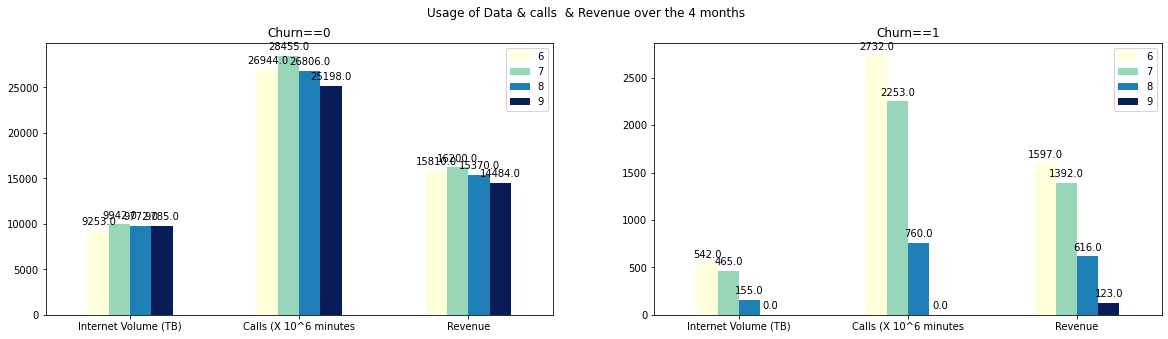

In [33]:
cols_ = ['vol_2g_mb', 'vol_3g_mb', 'total_ic_mou', 'total_og_mou', 'arpu']

df_0 = pd.DataFrame(columns=cols_) 
df_1 = pd.DataFrame(columns=cols_)
for mon in [6, 7, 8, 9]:
    for col in cols_:
        #print(mon, f'{col}_{mon}', int(df[f'{col}_{mon}'].sum()))
        df_0.loc[f'{mon}', col] = int(df[df['churn']==0][f'{col}_{mon}'].sum()/1000)
        df_1.loc[f'{mon}', col] = int(df[df['churn']==1][f'{col}_{mon}'].sum()/1000)


LABELS_USAGE_REVENUE = ['Internet Volume (TB)', 'Calls (X 10^6 minutes', 'Revenue']
df_0['Internet Volume (TB)'] = df_0['vol_2g_mb']+df_0['vol_3g_mb']
df_0['Calls (X 10^6 minutes'] = df_0['total_ic_mou']+df_0['total_og_mou']
df_0.rename(columns={'arpu':'Revenue'}, inplace=True)
df_0 = df_0[LABELS_USAGE_REVENUE].transpose()

df_1['Internet Volume (TB)'] = df_1['vol_2g_mb']+df_1['vol_3g_mb']
df_1['Calls (X 10^6 minutes'] = df_1['total_ic_mou']+df_1['total_og_mou']
df_1.rename(columns={'arpu':'Revenue'}, inplace=True)
df_1 = df_1[LABELS_USAGE_REVENUE].transpose()

fig = plt.figure(figsize=(20,5)); fig.suptitle("Usage of Data & calls  & Revenue over the 4 months")
ax = plt.subplot(1,2,1); ax = df_0.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==0"); ax.set_xticklabels(LABELS_USAGE_REVENUE, rotation=0)
ax = plt.subplot(1,2,2); ax = df_1.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==1"); ax.set_xticklabels(LABELS_USAGE_REVENUE, rotation=0)
print()

We can see that the usage and revenue falls drastically in the case of churn == 1. We can have the diff in usage and revenue as new features.

Let's see how the ```age on the network - number of days the customer is using the operator T network ```differs for customers who churn and who do not.

df_0 27299
df_1 2426



Text(0.5, 1.0, 'churn==1')

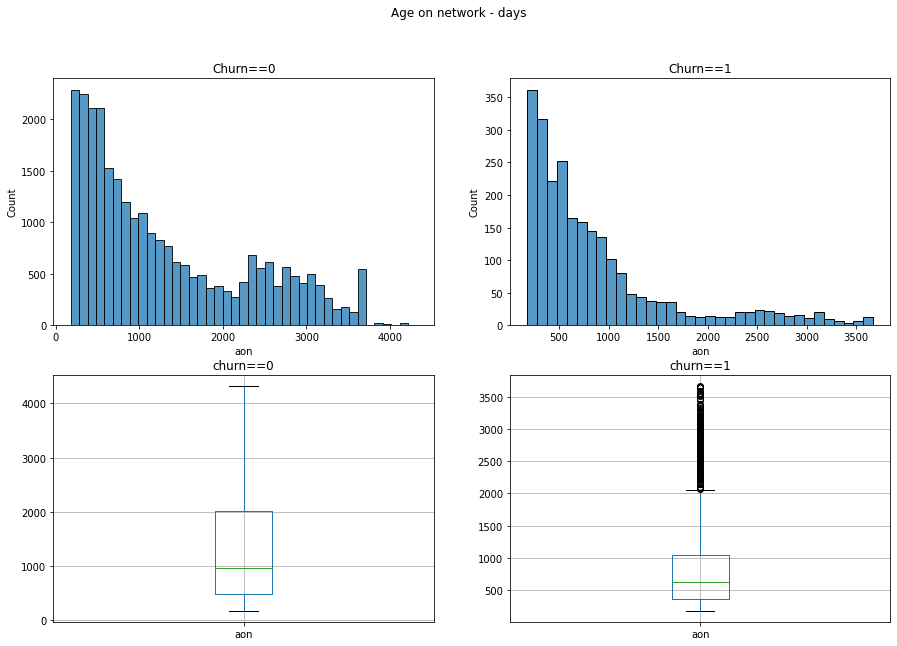

In [34]:
df_0 = df[df['churn']==0];print('df_0', df_0.shape[0])
df_1 = df[df['churn']==1];print('df_1', df_1.shape[0])

plt.figure(figsize=(15,10));plt.suptitle('Age on network - days')
ax = plt.subplot(2,2,1);sns.histplot(df_0, x='aon',ax=ax);ax.set_title("Churn==0")
ax = plt.subplot(2,2,2);sns.histplot(df_1, x='aon',ax=ax);ax.set_title("Churn==1"); print()

ax = plt.subplot(2,2,3);df_0.boxplot(column='aon', ax=ax); ax.set_title("churn==0")
ax = plt.subplot(2,2,4);df_1.boxplot(column='aon', ax=ax); ax.set_title("churn==1")

- Customers who do not churn have a typical aon - age on network of 1000 days
- Customers who churn have a typical on - age on network of 600 days

### Understand the groups of columns - ```Temporary```

In [35]:
listColumns(df)

171 ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_og_mou_9', 'isd_og

In [36]:
cols_imp = ['loc_ic_mou_6', 'loc_og_mou_6', 'std_ic_mou_6', 'std_og_mou_6','isd_ic_mou_6','isd_og_mou_6','spl_ic_mou_6', 'spl_og_mou_6', 'ic_others_6', 'og_others_6','roam_ic_mou_6',
'roam_og_mou_6', 'onnet_mou_6',  'offnet_mou_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'total_ic_mou_6',  'total_og_mou_6','arpu_6']
len(cols_imp)

19

In [37]:
COLS_NOT_PRESENT = []
for col in [
    'loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6',
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6',
'std_ic_t2o_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 
'std_og_t2c_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'count_rech_2g_6',
'count_rech_3g_6',

'total_rech_num_6',
'total_rech_amt_6', 
'total_rech_data_6', 

'max_rech_amt_6', 
'max_rech_data_6', 

'av_rech_amt_data_6', 

'date_of_last_rech_6',  
'date_of_last_rech_data_6', 
'last_day_rch_amt_6',  
'last_date_of_month_6', 

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6',
'monthly_2g_6',
'monthly_3g_6', 
'night_pck_user_6', ]:
    if col not in df.columns:
        COLS_NOT_PRESENT.append(col[:-1])
        print(col)
print(COLS_NOT_PRESENT)

std_ic_t2o_mou_6
std_og_t2c_mou_6
count_rech_2g_6
count_rech_3g_6
total_rech_data_6
max_rech_data_6
av_rech_amt_data_6
date_of_last_rech_data_6
last_date_of_month_6
night_pck_user_6
['std_ic_t2o_mou_', 'std_og_t2c_mou_', 'count_rech_2g_', 'count_rech_3g_', 'total_rech_data_', 'max_rech_data_', 'av_rech_amt_data_', 'date_of_last_rech_data_', 'last_date_of_month_', 'night_pck_user_']


In [38]:
COLS = df.columns
for col in COLS_NOT_PRESENT:
    for mon in [6, 7, 8, 9]:
        col_mon = f"{col}{mon}"
        if col_mon not in COLS:
            print(col_mon)

std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
count_rech_2g_6
count_rech_2g_7
count_rech_2g_8
count_rech_2g_9
count_rech_3g_6
count_rech_3g_7
count_rech_3g_8
count_rech_3g_9
total_rech_data_6
total_rech_data_7
total_rech_data_8
total_rech_data_9
max_rech_data_6
max_rech_data_7
max_rech_data_8
max_rech_data_9
av_rech_amt_data_6
av_rech_amt_data_7
av_rech_amt_data_8
av_rech_amt_data_9
date_of_last_rech_data_6
date_of_last_rech_data_7
date_of_last_rech_data_8
date_of_last_rech_data_9
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
night_pck_user_6
night_pck_user_7
night_pck_user_8
night_pck_user_9


'loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6'
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'total_rech_num_6',
'total_rech_amt_6', 

'max_rech_amt_6', 

'date_of_last_rech_6',  
'last_day_rch_amt_6',  

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6'
'monthly_2g_6',
'monthly_3g_6', 

In [39]:
COL_SCHEME = ['sachet_2g_6', 'sachet_3g_6','monthly_2g_6','monthly_3g_6']
print(100 * df[COL_SCHEME].isnull().sum()/df.shape[0])
for col in COL_SCHEME:
    print(col, len(df[col].unique()), df[col].unique())
df[COL_SCHEME].tail()

sachet_2g_6     0.0
sachet_3g_6     0.0
monthly_2g_6    0.0
monthly_3g_6    0.0
dtype: float64
sachet_2g_6 30 [ 0  4  1  3  7 12  5  2 10  8 16  9  6 19 11 22 14 20 13 17 18 25 21 32
 15 39 24 27 30 34]
sachet_3g_6 25 [ 0  1  3  8  2 10  5  4 13  7  6 29 16 18 12 11  9 23 14 19 15 21 22 17
 28]
monthly_2g_6 5 [0 2 1 3 4]
monthly_3g_6 12 [ 0  4  2  1  3  5  7  6  9  8 11 14]


,sachet_2g_6,sachet_3g_6,monthly_2g_6,monthly_3g_6
29720,1,0,0,0
29721,0,0,0,0
29722,1,0,0,0
29723,0,0,0,0
29724,1,1,0,1


In [40]:
for col in ['date_of_last_rech_6', 'last_day_rch_amt_6', ]:
    print(col, len(df[col].unique()))

date_of_last_rech_6 31
last_day_rch_amt_6 157


In [41]:
print(sorted(df['last_day_rch_amt_6'].unique().tolist()))
print(sorted(df['last_day_rch_amt_7'].unique().tolist()))

[0, 5, 7, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 60, 62, 65, 67, 68, 70, 75, 76, 77, 78, 86, 89, 90, 91, 95, 97, 98, 99, 100, 101, 102, 104, 107, 110, 116, 120, 125, 128, 145, 150, 152, 153, 154, 155, 169, 175, 179, 180, 194, 195, 198, 200, 201, 202, 215, 220, 225, 229, 230, 236, 250, 252, 269, 274, 279, 297, 300, 319, 325, 330, 339, 350, 351, 379, 390, 398, 399, 400, 410, 440, 455, 459, 500, 505, 550, 565, 599, 619, 650, 655, 750, 752, 755, 779, 790, 849, 855, 887, 951, 1000, 1001, 1010, 1050, 1098, 1100, 1255, 1479, 1500, 1555, 1580, 1649, 2000, 2010, 2100, 2199, 2933, 3010, 3100, 3299, 3350, 4010]
[0, 1, 4, 7, 9, 10, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 60, 62, 65, 66, 67, 68, 70, 75, 77, 78, 86, 90, 91, 95, 97, 98, 99, 100, 101, 102, 107, 108, 110

In [42]:
# 'total_ic_mou_6',
COLS_IC = ['loc_ic_mou_6', 'std_ic_mou_6', 'isd_ic_mou_6','spl_ic_mou_6', 'roam_ic_mou_6']#,'ic_others_6']
df_ = df[COLS_IC+['total_ic_mou_6']].copy()
df_['total_ic'] = df_[COLS_IC].sum(axis=1)
df_.head()

,loc_ic_mou_6,std_ic_mou_6,isd_ic_mou_6,spl_ic_mou_6,roam_ic_mou_6,total_ic_mou_6,total_ic
0,427.88,180.54,2.06,0.21,16.23,626.46,626.92
1,81.43,22.43,0.00,0.00,0.00,103.86,103.86
2,215.58,423.81,245.28,0.45,23.53,968.61,908.65
3,276.86,87.99,0.00,0.00,0.00,364.86,364.85
4,81.96,9.91,0.00,0.00,0.00,91.88,91.87


In [43]:
COLS_OG = ['loc_og_mou_6', 'std_og_mou_6', 'isd_og_mou_6','spl_og_mou_6', 'roam_og_mou_6','og_others_6']
df_ = df[COLS_OG+['total_og_mou_6']].copy()
df_['total_og'] = df_[COLS_OG].sum(axis=1)
(df_['total_og']-df_['total_og_mou_6']).head()

0    23.73
1    -0.01
2     7.98
3    -0.01
4    -0.02
dtype: float64

In [44]:
COLS_LOC_IC = getColumnsWithPrefix('loc_ic', COLS)
COLS_LOC_IC_6 = getColumnsWithSuffix('_6', COLS_LOC_IC)
df_ = df[COLS_LOC_IC_6].copy()
df_['total_loc_ic'] = df_[['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum(axis=1)
df_.head()

16 ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']
4 ['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6']


,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,total_loc_ic
0,58.14,217.56,152.16,427.88,427.86
1,23.84,57.58,0.00,81.43,81.42
2,67.88,142.88,4.81,215.58,215.57
3,41.33,226.81,8.71,276.86,276.85
4,34.54,47.41,0.00,81.96,81.95


- 'loc_ic_mou_6' is sum of 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6'. So should we drop the rest of the columns?

In [45]:
COLS_LOC_STD = getColumnsWithPrefix('std_og', COLS)
COLS_LOC_STD_6 = getColumnsWithSuffix('_6', COLS_LOC_STD)
df_ = df[COLS_LOC_STD_6].copy()
df_['total_std_og'] = df_[['std_og_t2t_mou_6', 'std_og_t2m_mou_6','std_og_t2f_mou_6']].sum(axis=1)
df_.head()

16 ['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_og_mou_9']
4 ['std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6']


,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,total_std_og
0,4.30,49.89,6.66,60.86,60.85
1,116.56,13.69,0.00,130.26,130.25
2,446.41,255.36,0.00,701.78,701.77
3,7.89,22.99,0.00,30.89,30.88
4,1146.91,1.55,0.00,1148.46,1148.46


In [46]:
# ONNET
# 'onnet_mou_6',
COLS_ONNET = [
        'loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_6', 
        'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6',
        'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6',
        'std_og_t2t_mou_6','std_og_t2f_mou_6', 
        ]
COLS_ONNET_6 = getColumnsWithSuffix('_6', COLS_ONNET)
df_ = df[COLS_ONNET_6 + ['onnet_mou_6']].copy()
df_['total_onnet'] = df_[COLS_ONNET_6].sum(axis=1)
df_.head()

9 ['loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6', 'std_og_t2t_mou_6', 'std_og_t2f_mou_6']


,loc_ic_t2t_mou_6,loc_ic_t2f_mou_6,loc_og_t2t_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_ic_t2t_mou_6,std_ic_t2f_mou_6,std_og_t2t_mou_6,std_og_t2f_mou_6,onnet_mou_6,total_onnet
0,58.14,152.16,51.39,62.13,0.0,36.89,52.19,4.30,6.66,57.84,423.86
1,23.84,0.00,297.13,0.00,0.0,0.00,0.00,116.56,0.00,413.69,437.53
2,67.88,4.81,49.63,4.54,0.0,115.68,0.00,446.41,0.00,501.76,688.95
3,41.33,8.71,42.61,0.00,0.0,68.79,0.51,7.89,0.00,50.51,169.84
4,34.54,0.00,38.99,0.00,0.0,8.63,0.00,1146.91,0.00,1185.91,1229.07


In [47]:
# OFFNET
df[['offnet_mou_6', 'loc_ic_t2m_mou_6', 'loc_og_t2m_mou_6', 'std_ic_t2m_mou_6', 'std_og_t2m_mou_6',]].head()

,offnet_mou_6,loc_ic_t2m_mou_6,loc_og_t2m_mou_6,std_ic_t2m_mou_6,std_og_t2m_mou_6
0,453.43,217.56,308.63,91.44,49.89
1,94.66,57.58,80.96,22.43,13.69
2,413.31,142.88,151.13,308.13,255.36
3,296.29,226.81,273.29,18.68,22.99
4,61.64,47.41,58.54,1.28,1.55


In [48]:
# Check if all the months have equal number of columns
getColumnsWithSuffix('_6', COLS);getColumnsWithSuffix('_7', COLS);getColumnsWithSuffix('_8', COLS);getColumnsWithSuffix('_9', COLS);print()

41 ['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'date_of_last_rech_6', 'last_day_rch_amt_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6']
41 ['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_

## Remove the month 9 columns

In [49]:
cols_month_9 = getColumnsWithSuffix('_9', COLS)
print("DF SHAPE:", df.shape, end=' --> ')
COLS = list(set(COLS) - set(cols_month_9))
df = df[COLS]
print(' --> ', df.shape)

41 ['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']
DF SHAPE: (29725, 171) -->  -->  (29725, 130)


<Figure size 720x432 with 0 Axes>

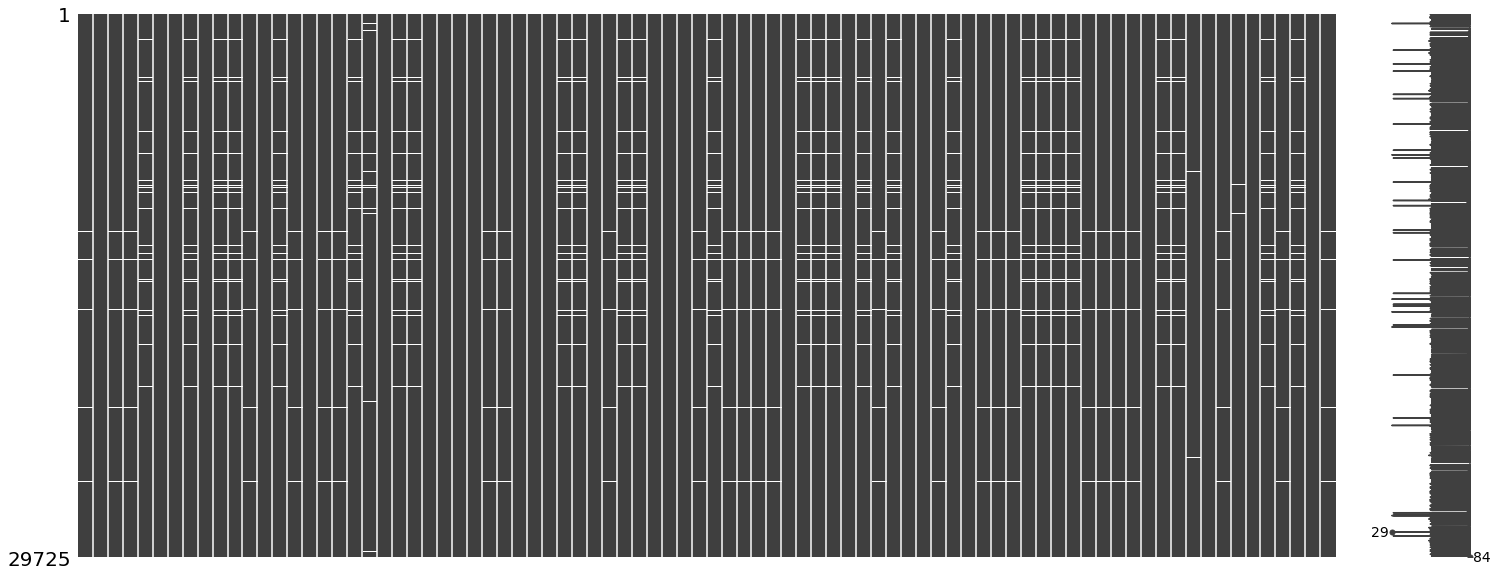

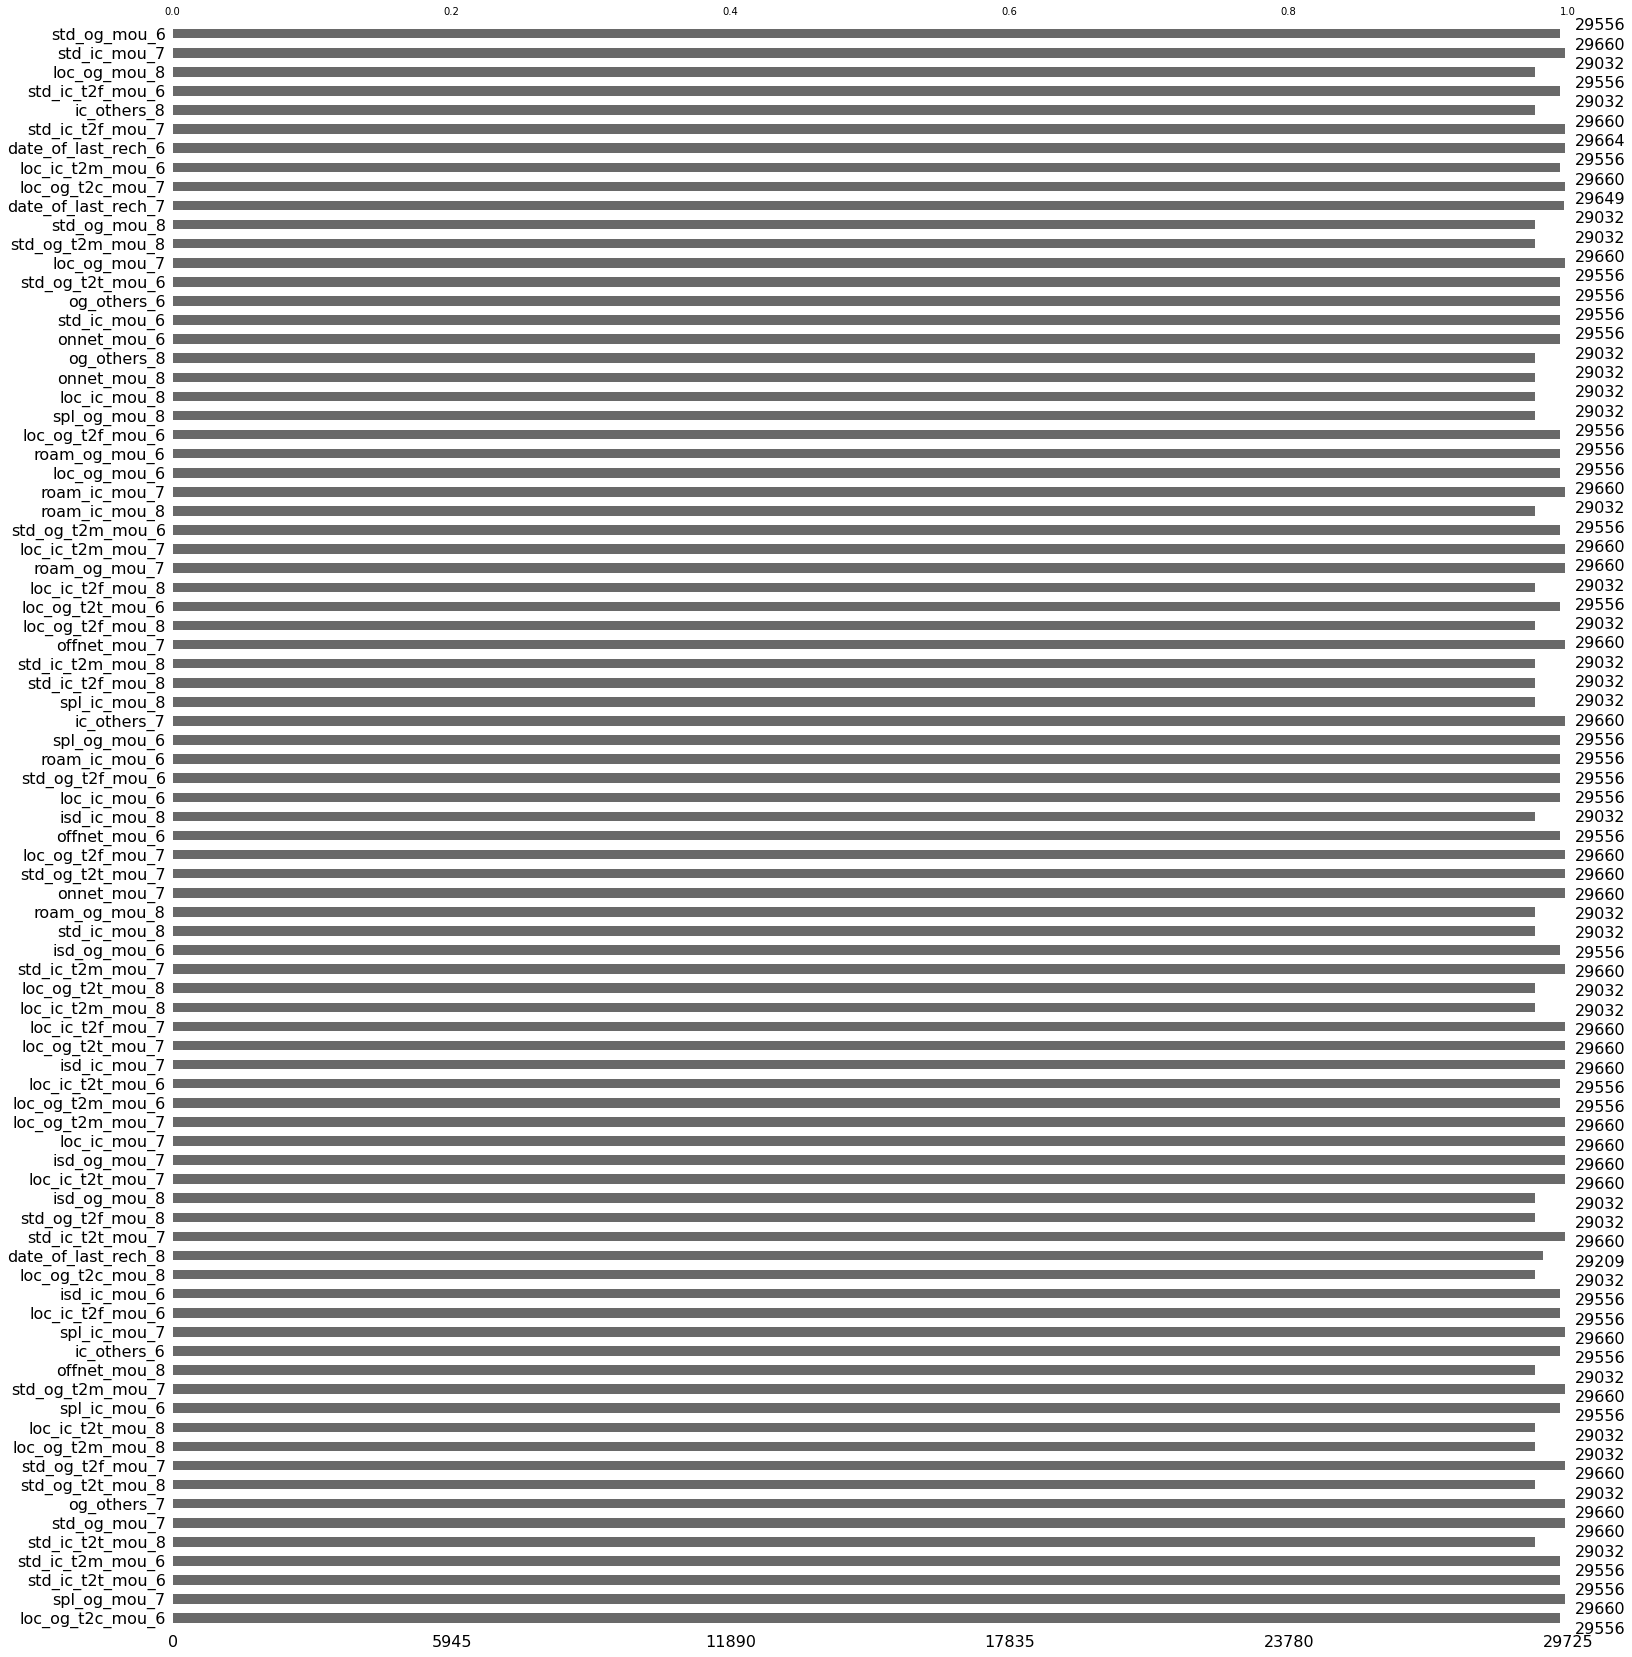

Columns with missing data: 84 64.62%
std_ic_t2t_mou_8, std_og_t2t_mou_8, loc_og_t2m_mou_8, loc_ic_t2t_mou_8, offnet_mou_8, loc_og_t2c_mou_8, std_og_t2f_mou_8, isd_og_mou_8, loc_ic_t2m_mou_8, loc_og_t2t_mou_8, std_ic_mou_8, roam_og_mou_8, isd_ic_mou_8, spl_ic_mou_8, std_ic_t2f_mou_8, std_ic_t2m_mou_8, loc_og_t2f_mou_8, loc_ic_t2f_mou_8, roam_ic_mou_8, spl_og_mou_8, loc_ic_mou_8, onnet_mou_8, og_others_8, std_og_t2m_mou_8, std_og_mou_8, ic_others_8, loc_og_mou_8, date_of_last_rech_8, loc_og_t2c_mou_6, std_ic_t2t_mou_6, std_ic_t2m_mou_6, spl_ic_mou_6, ic_others_6, loc_ic_t2f_mou_6, isd_ic_mou_6, loc_og_t2m_mou_6, loc_ic_t2t_mou_6, isd_og_mou_6, offnet_mou_6, loc_ic_mou_6, std_og_t2f_mou_6, roam_ic_mou_6, spl_og_mou_6, loc_og_t2t_mou_6, std_og_t2m_mou_6, loc_og_mou_6, roam_og_mou_6, loc_og_t2f_mou_6, onnet_mou_6, std_ic_mou_6, og_others_6, std_og_t2t_mou_6, loc_ic_t2m_mou_6, std_ic_t2f_mou_6, std_og_mou_6, date_of_last_rech_7, spl_og_mou_7, std_og_mou_7, og_others_7, std_og_t2f_mou_7, std_

In [50]:
displayColumnsWithMissingData(df)
COLS_MISS = listColumsWithMissingData(df, 0)
[print(col[0], end=', ') for col in COLS_MISS];print()

In [51]:
sum(df.isnull().values.any(axis=1))

1270

## Impute Missing Values

In [52]:
COLS_CAT = getCategoricalColumns(df)
#plotCategoricalVariables(df, COLS_CAT, "")

Columns with categorical values 3 --> ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


The columns date_of_last_rech_<mon> have the complete date. Month and year are redundant as they are same for all the rows. Let's just store the day alone.

In [53]:
for mon in [6,7,8]:
    col = f'date_of_last_rech_{mon}';print(col)
    print(df[col].unique())
    df[col] = df[col].apply(pd.to_datetime)
    df[col] = df[col].dt.day
    print(df[col].unique())
#plotCategoricalVariables(df, COLS_CAT, "")

date_of_last_rech_6
['6/27/2014' '6/25/2014' '6/20/2014' '6/30/2014' '6/23/2014' '6/24/2014'
 '6/29/2014' '6/28/2014' '6/26/2014' '6/21/2014' '6/17/2014' '6/22/2014'
 '6/13/2014' '6/16/2014' '6/12/2014' '6/15/2014' '6/18/2014' '6/8/2014'
 '6/19/2014' '6/2/2014' '6/7/2014' '6/4/2014' '6/14/2014' '6/11/2014' nan
 '6/9/2014' '6/10/2014' '6/3/2014' '6/5/2014' '6/1/2014' '6/6/2014']
[27. 25. 20. 30. 23. 24. 29. 28. 26. 21. 17. 22. 13. 16. 12. 15. 18.  8.
 19.  2.  7.  4. 14. 11. nan  9. 10.  3.  5.  1.  6.]
date_of_last_rech_7
['7/25/2014' '7/31/2014' '7/22/2014' '7/30/2014' '7/17/2014' '7/28/2014'
 '7/23/2014' '7/26/2014' '7/29/2014' '7/27/2014' '7/19/2014' '7/20/2014'
 '7/7/2014' '7/24/2014' '7/15/2014' '7/9/2014' '7/13/2014' '7/18/2014'
 '7/16/2014' '7/21/2014' nan '7/5/2014' '7/12/2014' '7/11/2014'
 '7/10/2014' '7/1/2014' '7/14/2014' '7/6/2014' '7/8/2014' '7/2/2014'
 '7/4/2014' '7/3/2014']
[25. 31. 22. 30. 17. 28. 23. 26. 29. 27. 19. 20.  7. 24. 15.  9. 13. 18.
 16. 21. nan  5. 12. 11. 

In [54]:
COLS_NUM = getNumericalColumns(df)
#plotNumericalVariables(df, COLS_NUM, "")
#plotBoxPlots(df, COLS_NUM)

Columns with numerical values 130 --> ['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'aug_vbc_3g', 'avg_rech_amt_67', 'churn', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'monthly

1. Categorical variables: Impute with mode
    - Towards the end of the month the recharge is higher
2. Numerical Variables 
    - w/o outliers: 'aon', 'isd_lc_mou_6', 'lou_lc_mou_6'. The missing values in these columns can be imputed with mean. 
    - Rest (with outliers) should be imputed with median values

In [55]:
print("Before", df.isnull().sum().sum())
print("DF SHAPE", df.shape, end='')

for column in COLS_MISS:
    col = column[0]
    if df[col].dtype == np.float64:
        if col in ['aon', 'isd_lc_mou_6', 'lou_lc_mou_6']:
            print(col)
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    elif df[col].dtype == 'object':
        #print(col,  df[col].dtype, df[col].mode().values[0])
        df[col].fillna(df[col].mode().values[0], inplace=True)

print("-->", df.shape)
print("After", df.isnull().sum().sum())

Before 25682
DF SHAPE (29725, 130)--> (29725, 130)
After 0


## Handle Outliers

3 1


<Figure size 720x576 with 0 Axes>

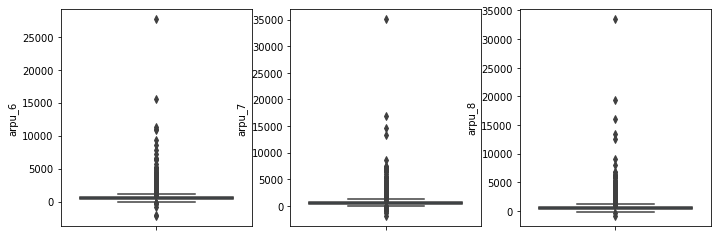

In [56]:
#Checking outliers in Average revenue per user for months 6,7 & 8
plt.figure(figsize=(10,8)); plotBoxPlots(df, ['arpu_6','arpu_7','arpu_8'])

We can see outliers in arpu exceeding 30000 , as some high valued customers might contribute very high revenues we will choose consider these genuine values and wont remove these.
But we can also see some negative values here.If a customer is not generating any revenue then the value has to be 0 ,it cannot be negative.So removing these values

In [57]:
# Removing negavtive outliers from arpu column
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['arpu_6'] >= 0) & (df['arpu_7'] >= 0) & (df['arpu_8'] >= 0)]
print(" --> ", df.shape)

DF SHAPE:  (29725, 130)  -->  (29587, 130)


3 1


<Figure size 720x576 with 0 Axes>

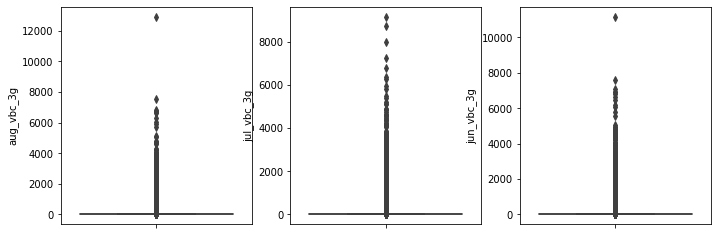

In [58]:
#Checking outliers in volume based cost per user for months 6,7 & 8
plt.figure(figsize=(10,8)); plotBoxPlots(df, ['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g'])

We can consider values above 10000 as outliers .

In [59]:
#Removing Outliers
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['aug_vbc_3g']<=10000) & (df['jul_vbc_3g']<=10000) & (df['jun_vbc_3g']<=10000) ]
print(" --> ", df.shape)

DF SHAPE:  (29587, 130)  -->  (29585, 130)


3 1


<Figure size 720x576 with 0 Axes>

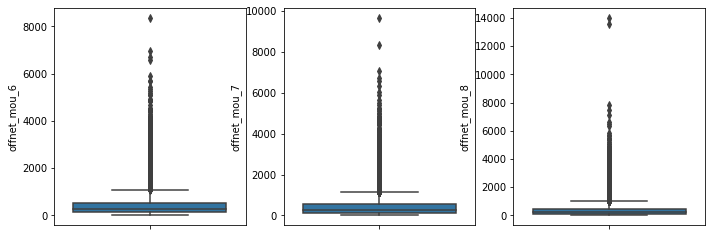

In [60]:
#Checking outliers in All kind of calls outside the operator T network  for months 6,7 & 8
plt.figure(figsize=(10,8))
plotBoxPlots(df, ['offnet_mou_6','offnet_mou_7','offnet_mou_8'])

We will remove these outliers above 7000

In [61]:
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['offnet_mou_6']<=7000) & (df['offnet_mou_7']<=7000) & (df['offnet_mou_8']<=7000) ]
print(" --> ", df.shape)

DF SHAPE:  (29585, 130)  -->  (29578, 130)


3 1


<Figure size 720x576 with 0 Axes>

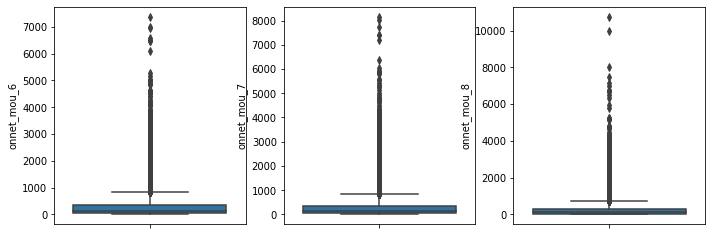

In [62]:
#Checking outliers in onnet for months 6,7 & 8
plt.figure(figsize=(10,8)); plotBoxPlots(df, ['onnet_mou_6','onnet_mou_7','onnet_mou_8'])

We will remove the outliers above 6000 and 8000 respectively

In [63]:
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['onnet_mou_6']<=6000) & (df['onnet_mou_7']<=8000) & (df['onnet_mou_8']<=8000) ]
print(" --> ", df.shape)

DF SHAPE:  (29578, 130)  -->  (29568, 130)


6 2


<Figure size 720x576 with 0 Axes>

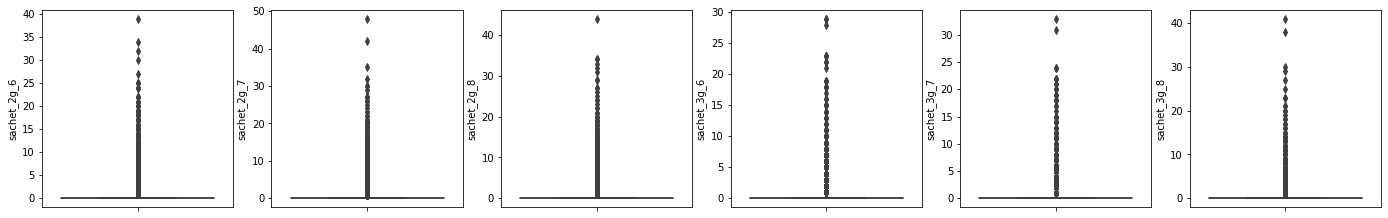

In [64]:
#Checking for outliers in sachet columns
plt.figure(figsize=(10,8));plotBoxPlots(df, ['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8','sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8'])

We can see few ouliers above 45

In [65]:
#Removing these outliers
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['sachet_2g_6']<=45) &(df['sachet_2g_7']<=45) &(df['sachet_2g_8']<=45) &(df['sachet_3g_6']<=25) &(df['sachet_3g_7']<=25) &(df['sachet_3g_8']<=25) ]
print(" --> ", df.shape)

DF SHAPE:  (29568, 130)  -->  (29558, 130)


12 3


<Figure size 1440x720 with 0 Axes>

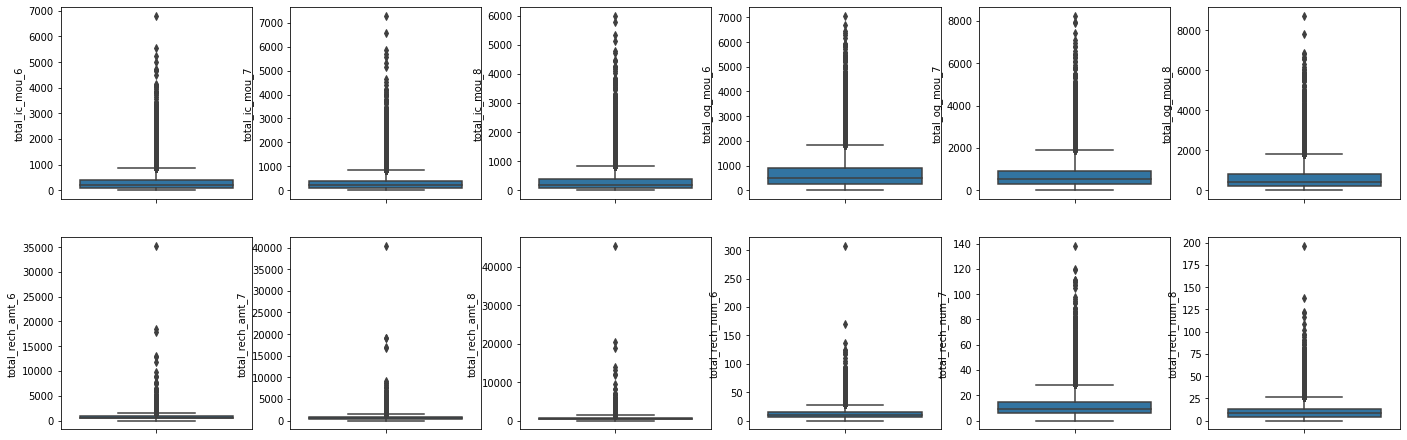

In [66]:
plt.figure(figsize=(20,10))
plotBoxPlots(df, ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8'])

There are quite a few outliers ,so we will be removing those.

In [67]:
print("DF SHAPE: ", df.shape, end=' ')
#Removing outliers
df = df[(df['total_ic_mou_6']<=6000) & (df['total_ic_mou_7']<=6000) & (df['total_ic_mou_8']<=6000) &
        (df['total_og_mou_6']<=8000) & (df['total_og_mou_7']<=8000) & (df['total_og_mou_8']<=8000) &
        (df['total_rech_amt_6']<=30000) & (df['total_rech_amt_7']<=30000) & (df['total_rech_amt_8']<=30000) &
        (df['total_rech_num_6']<=300) & (df['total_rech_num_7']<=300) & (df['total_rech_num_8']<=300) ]
print(" --> ", df.shape)

DF SHAPE:  (29558, 130)  -->  (29552, 130)


6 2


<Figure size 720x576 with 0 Axes>

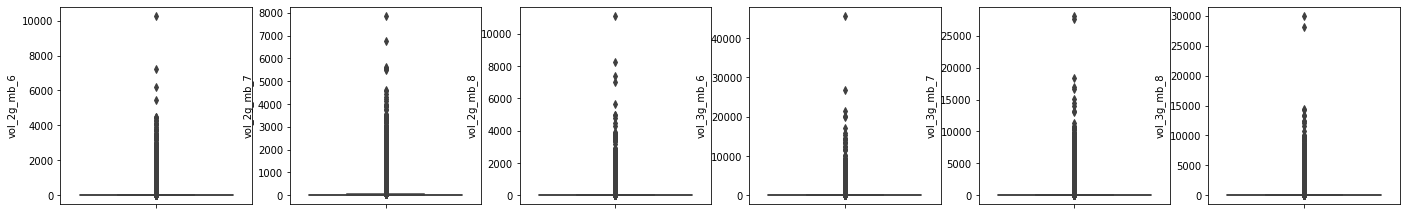

In [68]:
#Checking for outliers in Mobile internet usage volume (in MB)
plt.figure(figsize=(10,8));plotBoxPlots(df,['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'])

It can be observed here that outlier range drastically increases for 3g data. The highest outlier in 2g data is around 11000 whereas in 3g it is above 30000.

In [69]:
print("DF SHAPE: ", df.shape, end=' ')
#Removing outliers
df = df[(df['vol_2g_mb_6']<=8000) &(df['vol_2g_mb_7']<=8000) &(df['vol_2g_mb_8']<=8000) &
        (df['vol_3g_mb_6']<=40000) &(df['vol_3g_mb_7']<=20000) &(df['vol_3g_mb_8']<=30000) ]
print(" --> ", df.shape)

DF SHAPE:  (29552, 130)  -->  (29548, 130)


3 1


<Figure size 720x576 with 0 Axes>

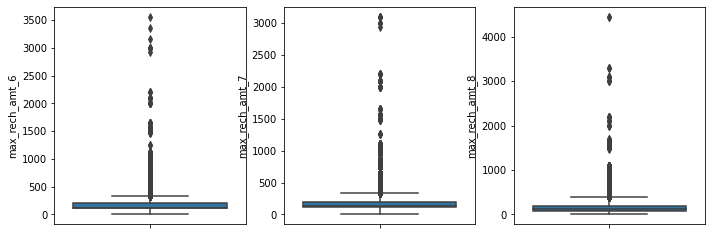

In [70]:
#Checking for outliers in column Max recharge amount
plt.figure(figsize=(10,8))
plotBoxPlots(df, [ 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8'])

Maximum recharge amount can vary for customers and its better not to remove these outliers as this might influence churn rate.

## Create Dummy variables
TODO: date_of_last_rech_6

## Derive new features

1. avg_rech_amt_67: average average recharge amount in the good phase (months 6 & 7)
2. 'vol_mb_67', 'vol_mb_78': Difference in the internet usage between the months 6,7 & 8
3. 'total_mou_67', 'total_mou_78': Difference in the calls between the months 6,7 & 8
4. 'arpu67', 'arpu_78': Difference in the revenue between the months 6,7 & 8

In [71]:
df['vol_mb_6'] = df['vol_2g_mb_6'] + df['vol_3g_mb_6']
df['vol_mb_7'] = df['vol_2g_mb_7'] + df['vol_3g_mb_7']
df['vol_mb_8'] = df['vol_2g_mb_8'] + df['vol_3g_mb_8']

df['vol_mb'] = df['vol_mb_6'] + df['vol_mb_7'] + df['vol_mb_8']
df['vol_mb_67'] = df['vol_mb_7'] - df['vol_mb_6']
df['vol_mb_78'] = df['vol_mb_8'] - df['vol_mb_7']

In [72]:
df['total_mou_6'] = df['total_ic_mou_6'] + df['total_og_mou_6']
df['total_mou_7'] = df['total_ic_mou_7'] + df['total_og_mou_7']
df['total_mou_8'] = df['total_ic_mou_8'] + df['total_og_mou_8']

df['total_mou'] = df['total_mou_6'] + df['total_mou_7'] + df['total_mou_8']
df['total_mou_67'] = df['total_mou_7'] - df['total_mou_6']
df['total_mou_78'] = df['total_mou_8'] - df['total_mou_7']

In [73]:
df['arpu']    = df['arpu_6'] + df['arpu_7'] + df['arpu_8']
df['arpu_67'] = df['arpu_7'] - df['arpu_6']
df['arpu_78'] = df['arpu_8'] - df['arpu_7']

In [74]:
df[['arpu', 'arpu_67', 'arpu_78']].head()

,arpu,arpu_67,arpu_78
0,5590.510,280.670,1821.630
1,1008.306,113.502,-354.861
2,1291.777,-287.175,387.589
3,918.738,-131.106,-111.975
4,734.487,-671.028,6.519


,churn,67,78
vol_mb,0,24.6,-7.0
total_mou,0,54.9,-61.9
arpu,0,14.1,-31.7
vol_mb,1,-27.5,-129.4
total_mou,1,-187.3,-615.3
arpu,1,-77.1,-319.0


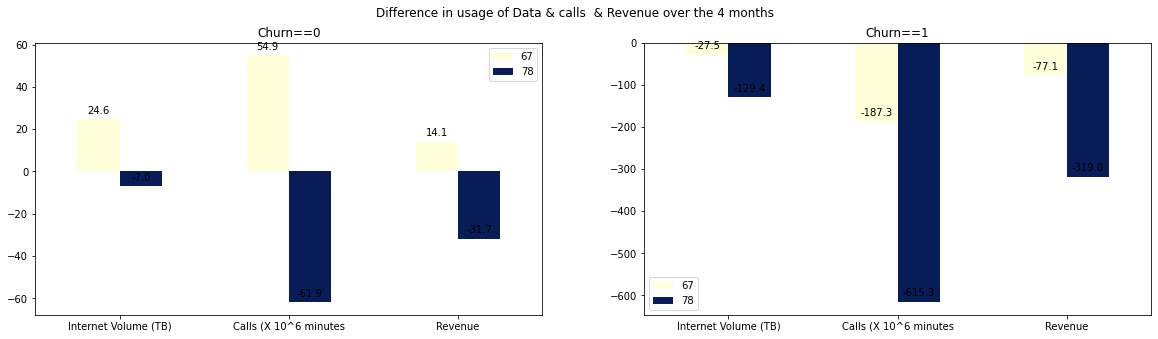

In [75]:
COLS_ = ['vol_mb', 'total_mou', 'arpu']

df_0 = pd.DataFrame(columns=COLS_) 
df_1 = pd.DataFrame(columns=COLS_)
for mon in [67, 78]:
    for col in COLS_:
        #print(mon, f'{col}_{mon}', int(df[f'{col}_{mon}'].mean()), int(df[f'{col}_{mon}'].median()))
        df_0.loc[f'{mon}', col] = df[df['churn']==0][f'{col}_{mon}'].mean().round(1)
        df_1.loc[f'{mon}', col] = df[df['churn']==1][f'{col}_{mon}'].mean().round(1)

COLS_USAGE_REVENUE = ['Internet Volume (TB)', 'Calls (X 10^6 minutes', 'Revenue']
df_0 = df_0.transpose()
df_1 = df_1.transpose()

fig = plt.figure(figsize=(20,5)); fig.suptitle("Difference in usage of Data & calls  & Revenue over the 4 months")
ax = plt.subplot(1,2,1); ax = df_0.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==0"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
ax = plt.subplot(1,2,2); ax = df_1.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==1"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
print()

df_0['churn'] = 0
df_1['churn'] = 1
pd.concat([df_0,df_1])[['churn','67','78']]

In [76]:
COLS = df.columns.tolist()

In [77]:
listColumns(df)

145 ['loc_og_t2c_mou_6', 'spl_og_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2t_mou_8', 'std_og_mou_7', 'og_others_7', 'vol_2g_mb_8', 'std_og_t2t_mou_8', 'std_og_t2f_mou_7', 'loc_og_t2m_mou_8', 'last_day_rch_amt_7', 'loc_ic_t2t_mou_8', 'spl_ic_mou_6', 'std_og_t2m_mou_7', 'total_rech_num_6', 'offnet_mou_8', 'ic_others_6', 'arpu_8', 'total_rech_amt_8', 'sachet_3g_6', 'spl_ic_mou_7', 'jun_vbc_3g', 'loc_ic_t2f_mou_6', 'isd_ic_mou_6', 'loc_og_t2c_mou_8', 'total_rech_num_7', 'sachet_2g_6', 'date_of_last_rech_8', 'aon', 'std_ic_t2t_mou_7', 'std_og_t2f_mou_8', 'sachet_3g_7', 'isd_og_mou_8', 'total_rech_amt_7', 'loc_ic_t2t_mou_7', 'isd_og_mou_7', 'loc_ic_mou_7', 'loc_og_t2m_mou_7', 'monthly_2g_7', 'loc_og_t2m_mou_6', 'loc_ic_t2t_mou_6', 'churn', 'total_og_mou_7', 'isd_ic_mou_7', 'sachet_2g_8', 'loc_og_t2t_mou_7', 'total_ic_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_t2m_mou_8', 'max_rech_amt_8', 'loc_og_t2t_mou_8', 'total_ic_mou_8', 'std_ic_t2m_mou_7', 'sep_vbc_3g', 'isd_og_mou_6', 'std_ic

In [78]:
df.shape

(29548, 145)

## Check correlations and drop 

In [79]:
def getTopNCorrelations(df, n):
    c = df.corr().abs()
    s = c.unstack()
    cldf = s.sort_values(kind="quicksort", ascending=False).to_frame().reset_index()
    cldf = cldf[cldf['level_0']!=cldf['level_1']]
    cldf = cldf.rename(columns={'level_0':'Variable1', 'level_1':'Variable2', 0:'CORR'})
    cldf['vars'] = cldf['Variable1'] + cldf['Variable2']
    cldf['vars'] = cldf['vars'].apply(lambda x: "".join(sorted(x)))
    cldf['CORR'] = round(cldf['CORR'], 2)
    cldf = cldf.drop_duplicates('vars')[['Variable1', 'Variable2', 'CORR']][0:n]
    return cldf

Variable2,arpu,arpu_7,arpu_8,isd_og_mou_7,isd_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,total_mou_7,total_mou_8,total_og_mou_6,total_og_mou_7,total_rech_amt_6,vol_3g_mb_6,vol_mb,vol_mb_7,vol_mb_8
Variable1,,,,,,,,,,,,,,,,,
arpu_6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.94,0.00,0.00,0.00,0.00
arpu_7,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
avg_rech_amt_67,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
isd_og_mou_6,0.00,0.00,0.00,0.92,0.92,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
isd_og_mou_7,0.00,0.00,0.00,0.00,0.92,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
total_ic_mou_6,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
total_ic_mou_7,0.00,0.00,0.00,0.00,0.00,0.00,0.88,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
total_ic_mou_8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
total_mou,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


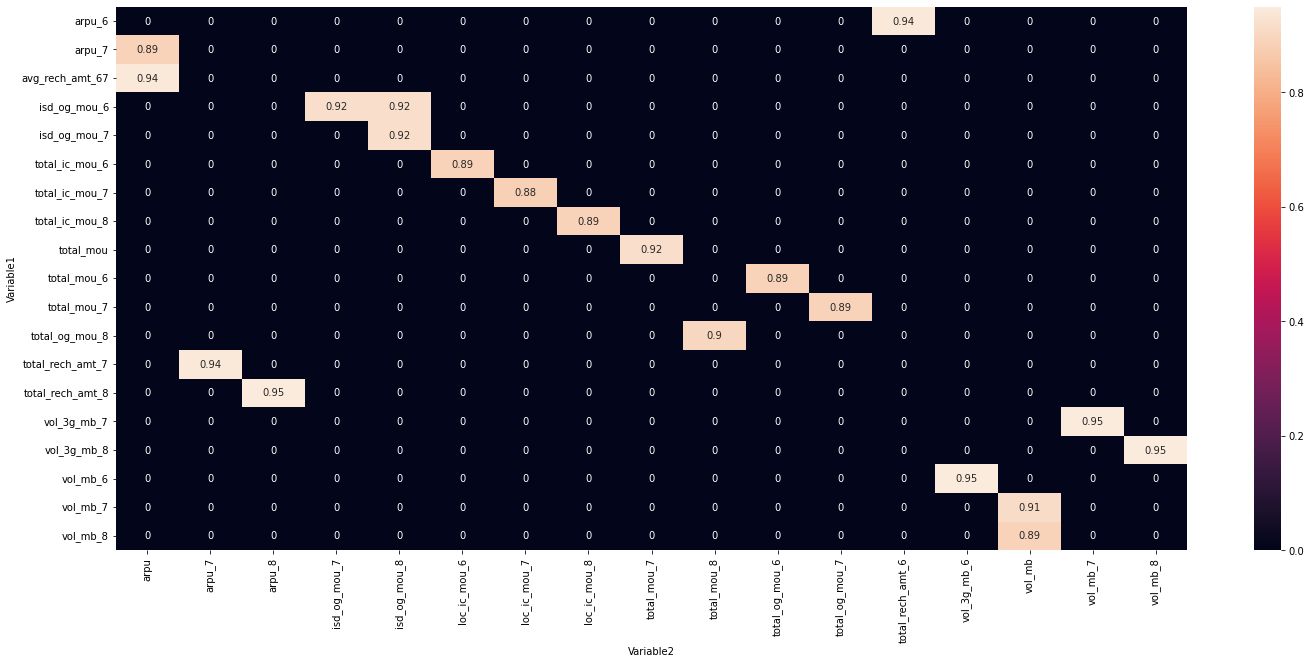

In [80]:
c1 = getTopNCorrelations(df, 20)
c1 = c1.head(20)
c1 = pd.pivot_table(data=c1, index='Variable1', columns='Variable2', values='CORR').fillna(0)
plt.figure(figsize = (24,10)); sns.heatmap(c1,annot = True)
c1

TODO: Re-check if anything is dropped

Variable2,avg_rech_amt_67,isd_og_mou_7,isd_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,onnet_mou_8,total_mou,total_mou_7,total_og_mou_6,total_og_mou_8,total_rech_amt_6,total_rech_amt_7,vol_mb,vol_mb_7,vol_mb_8
Variable1,,,,,,,,,,,,,,,,
arpu,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
avg_rech_amt_67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.87,0.88,0.00,0.00,0.00
isd_og_mou_6,0.00,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
isd_og_mou_7,0.00,0.00,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
loc_ic_t2m_mou_6,0.00,0.00,0.00,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
loc_ic_t2m_mou_8,0.00,0.00,0.00,0.00,0.00,0.85,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
std_og_t2t_mou_8,0.00,0.00,0.00,0.00,0.00,0.00,0.86,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
total_ic_mou_6,0.00,0.00,0.00,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
total_ic_mou_7,0.00,0.00,0.00,0.00,0.88,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00


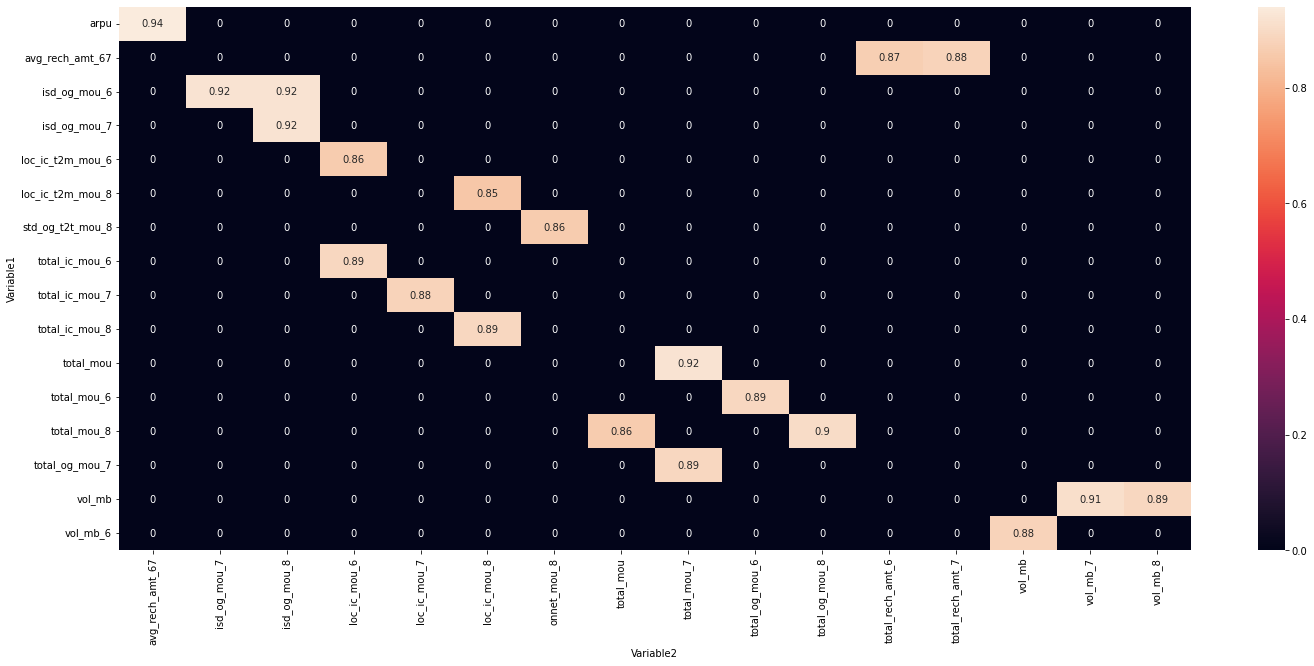

In [81]:
df_ = df.copy()
cols_to_drop = ['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_6', 'arpu_7', 'arpu_8', ]
df_.drop(columns=cols_to_drop, inplace=True)
c1 = getTopNCorrelations(df_, 20)
c1 = pd.pivot_table(data=c1, index='Variable1', columns='Variable2', values='CORR').fillna(0)
plt.figure(figsize = (24,10)); sns.heatmap(c1,annot = True)
c1

# Prepare data

In [82]:
df.shape

(29548, 145)

In [83]:
COLS_DATE = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
COLS_NUM = getNumericalColumns(df)
COLS_CAT = [getCategoricalColumns(df)]
COLS_NUM = list(set(COLS_NUM) - set(COLS_DATE))
print(len(COLS_NUM), COLS_NUM)

Columns with numerical values 145 --> ['aon', 'arpu', 'arpu_6', 'arpu_67', 'arpu_7', 'arpu_78', 'arpu_8', 'aug_vbc_3g', 'avg_rech_amt_67', 'churn', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'max_rech_amt_6', 'max_rech_amt_

In [84]:
listColumns(df)

145 ['loc_og_t2c_mou_6', 'spl_og_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2t_mou_8', 'std_og_mou_7', 'og_others_7', 'vol_2g_mb_8', 'std_og_t2t_mou_8', 'std_og_t2f_mou_7', 'loc_og_t2m_mou_8', 'last_day_rch_amt_7', 'loc_ic_t2t_mou_8', 'spl_ic_mou_6', 'std_og_t2m_mou_7', 'total_rech_num_6', 'offnet_mou_8', 'ic_others_6', 'arpu_8', 'total_rech_amt_8', 'sachet_3g_6', 'spl_ic_mou_7', 'jun_vbc_3g', 'loc_ic_t2f_mou_6', 'isd_ic_mou_6', 'loc_og_t2c_mou_8', 'total_rech_num_7', 'sachet_2g_6', 'date_of_last_rech_8', 'aon', 'std_ic_t2t_mou_7', 'std_og_t2f_mou_8', 'sachet_3g_7', 'isd_og_mou_8', 'total_rech_amt_7', 'loc_ic_t2t_mou_7', 'isd_og_mou_7', 'loc_ic_mou_7', 'loc_og_t2m_mou_7', 'monthly_2g_7', 'loc_og_t2m_mou_6', 'loc_ic_t2t_mou_6', 'churn', 'total_og_mou_7', 'isd_ic_mou_7', 'sachet_2g_8', 'loc_og_t2t_mou_7', 'total_ic_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_t2m_mou_8', 'max_rech_amt_8', 'loc_og_t2t_mou_8', 'total_ic_mou_8', 'std_ic_t2m_mou_7', 'sep_vbc_3g', 'isd_og_mou_6', 'std_ic

In [85]:
# Split df into train and test.
# Note: Use ```stratify``` to preserve the poportion of the target variable churn=1 & churn=0 in train and test datasets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[COL_TARGET])
print("TRAIN:", df_train.shape,"\n", df_train[COL_TARGET].value_counts(normalize=True)*100, "\n", sep='')
print("TEST:" , df_test.shape, "\n", df_test[COL_TARGET].value_counts(normalize=True)*100, "\n",  sep='')

# Create X_train & y_train
X_train = df_train[list(set(COLS)-set([COL_TARGET]))]
y_train = df_train[COL_TARGET]
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(type(X_train), type(y_train))

# Create X_test & y_test
X_test = df_test[list(set(COLS)-set([COL_TARGET]))]
y_test = df_test[COL_TARGET]
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(type(X_test), type(y_test))

TRAIN:(23638, 145)
0    92.00863
1     7.99137
Name: churn, dtype: float64

TEST:(5910, 145)
0    92.013536
1     7.986464
Name: churn, dtype: float64

X_train: (23638, 144), y_train: (23638,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
X_test: (5910, 144), y_test: (5910,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [86]:
cols = X_train.columns.tolist()

# Using MinMaxScaler as the numerical values (usage, revenue etc) should be > 0 
scaler = MinMaxScaler()
X_train[cols] = scaler.fit_transform(X_train)
print(type(X_train), type(y_train))
X_train.head()

X_test[cols] = scaler.transform(X_test[cols])
X_test.head()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


,loc_og_t2c_mou_6,std_ic_t2t_mou_6,spl_og_mou_7,std_ic_t2m_mou_6,std_ic_t2t_mou_8,std_og_mou_7,og_others_7,vol_2g_mb_8,std_og_t2t_mou_8,std_og_t2f_mou_7,...,aug_vbc_3g,ic_others_8,std_ic_t2f_mou_6,total_og_mou_6,loc_og_mou_8,total_mou_8,monthly_2g_6,std_ic_mou_7,std_og_mou_6,monthly_3g_7
8602,0.000000,0.001220,0.015587,0.004294,0.0,0.032719,0.0,0.00000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.051145,0.066955,0.147327,0.00,0.011770,0.006154,0.000000
23119,0.000000,0.000000,0.003642,0.000400,0.0,0.000381,0.0,0.00000,0.0,0.002956,...,0.000000,0.000000,0.000000,0.093938,0.083701,0.123118,0.00,0.000160,0.000000,0.000000
5142,0.003004,0.000319,0.020959,0.001918,0.0,0.068003,0.0,0.00000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.126517,0.000000,0.000000,0.00,0.000315,0.144157,0.000000
105,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.03042,0.0,0.000000,...,0.204555,0.000432,0.000000,0.052217,0.024570,0.049709,0.25,0.002518,0.000139,0.000000
11349,0.000000,0.000899,0.003381,0.000790,0.0,0.002064,0.0,0.00000,0.0,0.000000,...,0.091905,0.000000,0.002228,0.035630,0.031442,0.069053,0.00,0.000048,0.000471,0.071429


## Perform dimensionality reduction

# Build model to predict customers who will churn - with PCA

# Build model to identify indicators of churn - w/o PCA

## Logistic Regression - 1

#### Functions - Build Model

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

#COLS_DROPPED = []
def runRFE(numFeatures, X, y):
    #global COLS_DROPPED
    #COLS_DROPPED = []
    
    lm = LogisticRegression()
    rfe = RFE(lm, numFeatures)
    rfe = rfe.fit(X,y)
    list(zip(X.columns, rfe.support_, rfe.ranking_))
    cols = X.columns[rfe.support_].tolist()
    print("Columns selected by RFE:", len(cols), cols)

    cols_dropped = list(set(X.columns)-set(cols))
    #COLS_DROPPED.extend(list(set(X.columns)-set(X.columns[rfe.support_].tolist())))
    print("Columns dropped by RFE:", len(cols_dropped), cols_dropped)

    return cols

# Build a  Linear Regression Model
def buildLogRegModel(X, y):
    X_sm = sm.add_constant(X)

    # create the model
    lr = sm.GLM(y, X_sm, family = sm.families.Binomial())
    lr_model = lr.fit()
    #print(lr_model.params)
    print(lr_model.summary())
    return lr_model, X_sm

# Calculate & print VIF
def getVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

# Drop one column from the current dataset and build the model. Store the dropped column in dropped_cols so that these can be dropped from the test dataset also
def dropColumnAndBuildModel(X, y, col=""):
    #global COLS_DROPPED
    print(len(X.columns))
    if col != "":  
        X.drop(columns=col, inplace=True)
        #COLS_DROPPED.append(col)
    lr_model, X_sm = buildLogRegModel(X, y)
    getVIF(X)
    return lr_model, X_sm

### Build Model

In [88]:
X_train_1 = X_train.copy(); y_train_1 = y_train.copy()
X_test_1 = X_test.copy();   y_test_1 = y_test.copy()

In [89]:
# Build a Logistic regression model
logreg = sm.GLM(y_train_1,(sm.add_constant(X_train_1)), family = sm.families.Binomial())
logreg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23509
Model Family:                Binomial   Df Model:                          128
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3955.0
Date:                Tue, 28 Dec 2021   Deviance:                       7910.0
Time:                        11:57:38   Pearson chi2:                 2.50e+06
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4838.2783    910.711      5.313      0.000    3053.318    6623.239
loc_og_t2c_mou_6       -1.1045      1.673     -0.660      0.509      -4.384       2.175
std_ic_t2t_mou_6    -7.964e+04   3.44e+04     -2.314      0.021   -1.47e+05   -1.22e+04
spl_og_mou_7        -6848.0452   4032.362     -1.698      0.089   -1.48e+04    1055.239
std_ic_t2m_mou_6    -6.755e+04   2.92e+04     -2.315      0.021   -1.25e+05   -1.03e+04
std_ic_t2t_mou_8     2.407e+04   3.31e+04      0.727      0.467   -4.08e+04    8.89e+04
std_og_mou_7          5.21e+04   4.18e+04      1.245      0.213   -2.99e+04    1.34e+05
og_others_7         -2002.6224   1178.932     -1.699      0.089   -4313.286     308.041
vol_2g_mb_8          -273.9508     50.790     -5.394      0.000    -373.497    -174.405
std_og_t2t_mou_8     1.629e+05   4.76e+04      3.422      0.001    6.96e+04    2.56e+05
std_og_t2f_mou_7    -6631.1181   3433.257     -1.931      0.053   -1.34e+04      97.943
loc_og_t2m_mou_8      7.09e+04   2.18e+04      3.260      0.001    2.83e+04    1.14e+05
last_day_rch_amt_7      0.0502      0.703      0.071      0.943      -1.327       1.427
arpu_78              1369.1965    257.465      5.318      0.000     864.574    1873.819
loc_ic_t2t_mou_8     1.883e+05   2.34e+04      8.040      0.000    1.42e+05    2.34e+05
spl_ic_mou_6          -56.9242     90.559     -0.629      0.530    -234.417     120.569
std_og_t2m_mou_7    -7.878e+04   4.08e+04     -1.931      0.053   -1.59e+05    1167.454
total_mou_78        -1.746e+04   3263.246     -5.350      0.000   -2.39e+04   -1.11e+04
total_rech_num_6       -0.4277      0.898     -0.476      0.634      -2.188       1.333
offnet_mou_8          -20.2901     23.306     -0.871      0.384     -65.970      25.390
ic_others_6         -1856.5486   2659.260     -0.698      0.485   -7068.603    3355.505
arpu_8              -1073.2815    203.181     -5.282      0.000   -1471.508    -675.055
arpu                 -131.8130     25.912     -5.087      0.000    -182.600     -81.026
vol_mb                146.7475     27.736      5.291      0.000      92.386     201.109
total_rech_amt_8      -10.3333      6.480     -1.595      0.111     -23.034       2.367
sachet_3g_6            -1.0714      1.542     -0.695      0.487      -4.094       1.951
vol_mb_78            2088.2336    393.229      5.310      0.000    1317.519    2858.949
spl_ic_mou_7          116.9859    104.227      1.122      0.262     -87.296     321.267
jun_vbc_3g              0.4991      1.265      0.394      0.693      -1.980       2.979
loc_ic_t2f_mou_6    -5337.2186   7345.187     -0.727      0.467   -1.97e+04    9059.083
isd_ic_mou_6        -1.256e+04    1.8e+04     -0.698      0.485   -4.78e+04    2.27e+04
loc_og_t2c_mou_8        1.0581      2.307      0.459      0.646      -3.463       5.579
tot

In [90]:
# Run RFE and then build the model
features_1 = runRFE(15, X_train_1, y_train_1 )
X_train_1  = X_train_1[features_1]
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1)

Columns selected by RFE: 15 ['arpu_78', 'total_mou_78', 'max_rech_amt_8', 'total_ic_mou_8', 'vol_mb_8', 'spl_ic_mou_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'total_og_mou_8', 'std_og_mou_8', 'total_mou_8']
Columns dropped by RFE: 129 ['loc_og_t2c_mou_6', 'std_ic_t2t_mou_6', 'spl_og_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2t_mou_8', 'std_og_mou_7', 'og_others_7', 'vol_2g_mb_8', 'std_og_t2t_mou_8', 'std_og_t2f_mou_7', 'loc_og_t2m_mou_8', 'last_day_rch_amt_7', 'loc_ic_t2t_mou_8', 'spl_ic_mou_6', 'std_og_t2m_mou_7', 'total_rech_num_6', 'offnet_mou_8', 'ic_others_6', 'arpu_8', 'arpu', 'vol_mb', 'total_rech_amt_8', 'sachet_3g_6', 'vol_mb_78', 'spl_ic_mou_7', 'jun_vbc_3g', 'loc_ic_t2f_mou_6', 'isd_ic_mou_6', 'loc_og_t2c_mou_8', 'total_rech_num_7', 'vol_mb_67', 'sachet_2g_6', 'arpu_67', 'date_of_last_rech_8', 'aon', 'std_ic_t2t_mou_7', 'std_og_t2f_mou_8', 'sachet_3g_7', 'isd_og_mou_8', 'total_rech_amt_7', 'loc_ic_t2t_mou_7', 'isd_og_

In [91]:
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='total_mou_8')

15
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23623
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4477.4
Date:                Tue, 28 Dec 2021   Deviance:                       8954.9
Time:                        11:58:15   Pearson chi2:                 5.18e+09
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.0155    

In [92]:
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='max_rech_amt_8')

14
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23624
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4477.6
Date:                Tue, 28 Dec 2021   Deviance:                       8955.2
Time:                        11:58:15   Pearson chi2:                 5.42e+09
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.0161    

In [93]:
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='total_mou_78')

13
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23625
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4532.8
Date:                Tue, 28 Dec 2021   Deviance:                       9065.6
Time:                        11:58:15   Pearson chi2:                 8.79e+10
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.2492    

In [94]:
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='total_og_mou_8')

12
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23626
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4662.6
Date:                Tue, 28 Dec 2021   Deviance:                       9325.1
Time:                        11:58:15   Pearson chi2:                 1.79e+11
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.1556    

In [95]:
'''# Get the list of Features in the model
print("All Features", len(features_1), features_1, "\nDropped Features in RFE", len(COLS_DROPPED), COLS_DROPPED)
features_1 = list(set(features_1) - set(COLS_DROPPED))
print("Features in the model", len(features_1), features_1)'''

# Get the list of columns in the model
cols_dropped = list(set(features_1) - set(X_train_1.columns))
print("All Features", len(features_1), features_1, "\nDropped Features", len(cols_dropped), cols_dropped)
features_1 = X_train_1.columns.tolist()
print("Features in the model", len(features_1), features_1)

All Features 15 ['arpu_78', 'total_mou_78', 'max_rech_amt_8', 'total_ic_mou_8', 'vol_mb_8', 'spl_ic_mou_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'total_og_mou_8', 'std_og_mou_8', 'total_mou_8'] 
Dropped Features 4 ['max_rech_amt_8', 'total_mou_78', 'total_mou_8', 'total_og_mou_8']
Features in the model 11 ['arpu_78', 'total_ic_mou_8', 'vol_mb_8', 'spl_ic_mou_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'std_og_mou_8']


### Evaluate Model

In [96]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

DF_SUMMARY = pd.DataFrame(columns=['Category', 'Features', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'AUC'])
# Prints the following evaluation metrics of a classification model. 
# metrics: confusion_matrix, accuracy, sensitivity, specificity, FPR, PPV, plots ROC curve
#   category: 'TRAIN' or 'TEST'
#   y_actual, y_predicted: The actual target and predicted values
def evaluate_classification_model(category, features, y_actual, y_predicted):
    global DF_SUMMARY
    #y_predicted = classifier.predict(X)
    #print(f"{category} Accuracy : {percent(accuracy_score(y_actual, y_predicted), 1)}%")
    print(f"{category} Confusion Matrix:")
    confusion = confusion_matrix(y_actual, y_predicted)
    TP, TN,FP, FN  = confusion[1,1], confusion[0,0], confusion[0,1], confusion[1,0]
    print(f"TP: {TP}, TN: {TN}, FP:{FP}, FN:{FN}")
    print(confusion)
    
    sensitivity = TP/float (TP+FN); sensitivity=round(sensitivity*100,2)
    specificity = TN/float (TN+FP); specificity = round(specificity*100,2)
    fpr = FP/float(TN+FP); fpr = round(fpr*100,2)
    ppv = TP/float(TP+FP); ppv = round(ppv*100,2)

    accuracy    = round(100 * accuracy_score(y_actual, y_predicted),2)

    print(classification_report(y_actual, y_predicted))
    precision   = round(100 * metrics.precision_score(y_actual, y_predicted), 2)
    recall      = round(100 * metrics.recall_score(y_actual, y_predicted), 2)

    print(f"Accuracy: % {accuracy} Sensitivity: {sensitivity}% Specificity: {specificity}% Precision: {precision}% Recall: {recall}% FPR: {fpr}% PPV: {ppv}%")
    #print(f"Sensitivity: {round(sensitivity*100,2)}% Specificity: {round(specificity*100,2)}% FPR: {round(fpr*100,2)}% PPV: {round(ppv*100,2)}%")

    auc_score = round(100 * draw_roc(y_actual, y_predicted),2)

    metrics_ = {'Category': category,'Num Features': len(features), 'Features': features, 'Accuracy': accuracy, 'Sensitivity': sensitivity, 'Specificity': specificity, 'Precision': precision, 'Recall': recall, 'AUC':auc_score }
    DF_SUMMARY = DF_SUMMARY.append(metrics_, ignore_index = True)
    return metrics_

# Calculate & print VIF
def getVIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

def draw_roc (actual,probs):
    fpr,tpr,_ = metrics.roc_curve (actual,probs,drop_intermediate = False)
    auc_score = metrics.roc_auc_score(actual,probs)
    plt.figure (figsize =(5,5))
    #plt.figure()
    plt.plot(fpr, tpr, label = 'ROC Curve(area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0]); plt.xlabel('False Positive Rate')
    plt.ylim([0.0, 1.05]); plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - Lead Score')
    plt.legend(loc="lower right")

    plt.show()
    return auc_score

def predict(model, X, y, prob=0.5):
    y_pred = model.predict(X)
    #print(y_pred [:5])
    #print((y_pred*100).astype(int)[:5])

    y_pred = y_pred.values.reshape(-1)
    #print(y_pred[:5])

    y_pred_final = pd.DataFrame ({'Actual': y.values, 'Prob' : y_pred})
    y_pred_final['ID'] = y.index
    y_pred_final.index = y.index
    #print(y_pred_final.head())

    y_pred_final['Predicted'] = y_pred_final['Prob'].map(lambda x: 1 if x>prob else 0)

    ## LOOK at the head of the data
    print(y_pred_final.head())
    return y_pred_final

def predAndEvaluateForVariousCutoffs(y_pred):
    # Predict for various cut-offs 
    numbers = [float(x)/10 for x in range (10)]
    for i in numbers:
        y_pred[i] = y_pred['Prob'].map(lambda x: 1 if x>i else 0)

    # Calculate accuracy, sensitivity & specificity for probab cut offs
    cutoff_df = pd.DataFrame(columns=['prob','accuracy','sensi','speci'])
    for i in numbers:
        cm1 = metrics.confusion_matrix(y_pred['Actual'],y_pred[i])
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] = [i,accuracy,sensi,speci]
    print(cutoff_df)

    # plot accuracy, sensitivity & specificity
    plt.figure(figsize=(10,10))
    cutoff_df.plot.line(x='prob',y=['accuracy','sensi','speci'])
    plt.show()
    return y_pred.head()

#### Training dataset

In [97]:
print(features_1)

['arpu_78', 'total_ic_mou_8', 'vol_mb_8', 'spl_ic_mou_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'std_og_mou_8']


       Actual      Prob     ID  Predicted
3239        0  0.001967   3239          0
1834        0  0.078511   1834          0
17891       0  0.000197  17891          0
26061       0  0.010476  26061          0
3091        0  0.161792   3091          0

Logistic Regression - TRAIN - o.5 cut-off Confusion Matrix:
TP: 300, TN: 21574, FP:175, FN:1589
[[21574   175]
 [ 1589   300]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     21749
           1       0.63      0.16      0.25      1889

    accuracy                           0.93     23638
   macro avg       0.78      0.58      0.61     23638
weighted avg       0.91      0.93      0.90     23638

Accuracy: % 92.54 Sensitivity: 15.88% Specificity: 99.2% Precision: 63.16% Recall: 15.88% FPR: 0.8% PPV: 63.16%


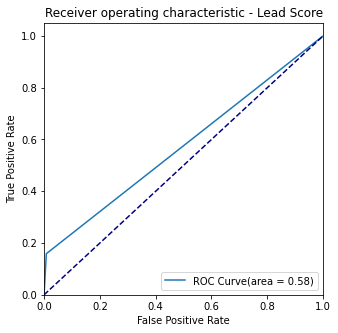

In [98]:
# Predict using probability of 0.5
y_train_pred_final_1 = predict(lr_model_1, X_train_sm_1, y_train_1); print()
_ = evaluate_classification_model("Logistic Regression - TRAIN - o.5 cut-off", features_1, y_train_pred_final_1['Actual'], y_train_pred_final_1['Predicted'])

     prob  accuracy     sensi     speci
0.0   0.0  0.079914  1.000000  0.000000
0.1   0.1  0.824943  0.789307  0.828038
0.2   0.2  0.906591  0.665431  0.927537
0.3   0.3  0.928336  0.557967  0.960504
0.4   0.4  0.930366  0.344097  0.981286
0.5   0.5  0.925374  0.158814  0.991954
0.6   0.6  0.923090  0.077290  0.996552
0.7   0.7  0.921736  0.034939  0.998759
0.8   0.8  0.920932  0.016411  0.999494
0.9   0.9  0.920509  0.006882  0.999862


<Figure size 720x720 with 0 Axes>

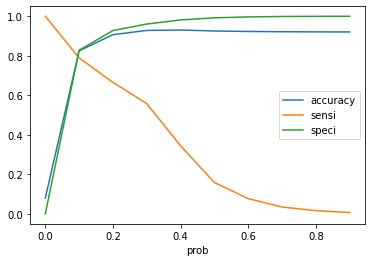

,Actual,Prob,ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
3239,0,0.001967,3239,0,1,0,0,0,0,0,0,0,0,0
1834,0,0.078511,1834,0,1,0,0,0,0,0,0,0,0,0
17891,0,0.000197,17891,0,1,0,0,0,0,0,0,0,0,0
26061,0,0.010476,26061,0,1,0,0,0,0,0,0,0,0,0
3091,0,0.161792,3091,0,1,1,0,0,0,0,0,0,0,0


In [99]:
predAndEvaluateForVariousCutoffs(y_train_pred_final_1)

From the plot, the optimal cut- off is 0.1

Logistic Regression - TRAIN - Optimum cut-off Confusion Matrix:
TP: 1491, TN: 18009, FP:3740, FN:398
[[18009  3740]
 [  398  1491]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     21749
           1       0.29      0.79      0.42      1889

    accuracy                           0.82     23638
   macro avg       0.63      0.81      0.66     23638
weighted avg       0.92      0.82      0.86     23638

Accuracy: % 82.49 Sensitivity: 78.93% Specificity: 82.8% Precision: 28.5% Recall: 78.93% FPR: 17.2% PPV: 28.5%


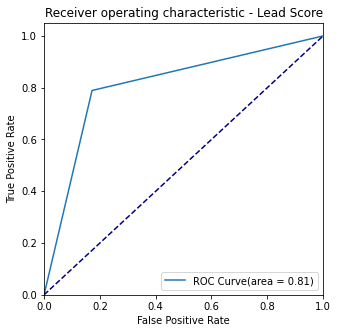

In [100]:
OPTIMUM_CUTOFF = 0.1

# Predict the class using the optinal cut-off
_ = evaluate_classification_model("Logistic Regression - TRAIN - Optimum cut-off", features_1, y_train_pred_final_1['Actual'], y_train_pred_final_1[OPTIMUM_CUTOFF])

ROC on the training dataset is 79%. Recall/Sensitivity is 79%

#### Test dataset

In [101]:
X_test_1 = X_test_1[features_1]
X_test_1.head()

,arpu_78,total_ic_mou_8,vol_mb_8,spl_ic_mou_8,roam_og_mou_7,arpu_6,monthly_3g_8,monthly_2g_8,total_rech_num_8,last_day_rch_amt_8,std_og_mou_8
8602,0.477909,0.075021,0.000000,0.0,0.0,0.023975,0.0,0.0,0.168367,0.002248,0.049080
23119,0.493076,0.072739,0.000000,0.0,0.0,0.055221,0.0,0.0,0.040816,0.029220,0.000000
5142,0.469291,0.000000,0.000000,0.0,0.0,0.026274,0.0,0.0,0.025510,0.000000,0.000000
105,0.482535,0.041311,0.119563,0.0,0.0,0.039248,0.0,0.2,0.025510,0.011238,0.000476
11349,0.473097,0.061243,0.000000,0.0,0.0,0.031569,0.0,0.0,0.015306,0.029220,0.000199


12 ['const', 'arpu_78', 'total_ic_mou_8', 'vol_mb_8', 'spl_ic_mou_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'std_og_mou_8']
       Actual      Prob     ID  Predicted
8602        0  0.004900   8602          0
23119       0  0.010327  23119          0
5142        0  0.346670   5142          1
105         0  0.010325    105          0
11349       0  0.027486  11349          0
Logistic Regression - TEST Confusion Matrix:
TP: 375, TN: 4539, FP:899, FN:97
[[4539  899]
 [  97  375]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      5438
           1       0.29      0.79      0.43       472

    accuracy                           0.83      5910
   macro avg       0.64      0.81      0.67      5910
weighted avg       0.92      0.83      0.86      5910

Accuracy: % 83.15 Sensitivity: 79.45% Specificity: 83.47% Precision: 29.43% Recall: 79.45% FPR: 16.53% PPV: 29.43%


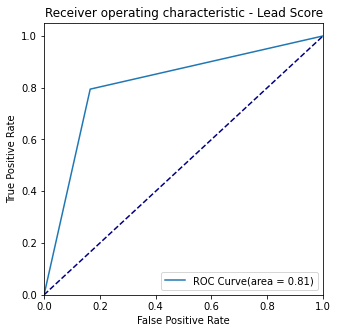

In [102]:
## Predict using the optimum cut-off
X_test_sm_1 = sm.add_constant(X_test_1)
print(len(X_test_sm_1.columns.tolist()), X_test_sm_1.columns.tolist())
y_test_pred_final_1 =  predict(lr_model_1, X_test_sm_1, y_test_1, OPTIMUM_CUTOFF)
_ = evaluate_classification_model("Logistic Regression - TEST", features_1, y_test_pred_final_1['Actual'], y_test_pred_final_1['Predicted'])

## Logistic Regression - 2

### Build model

In [103]:
X_train_2 = X_train.copy(); y_train_2 = y_train.copy()
X_test_2  = X_test.copy();  y_test_2  = y_test.copy()

In [104]:
# Run RFE and then build the model
#COLS_DROPPED = []
features_2 = runRFE(30, X_train_2, y_train_2 )
X_train_2 = X_train_2[features_2]
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2)

Columns selected by RFE: 30 ['vol_2g_mb_8', 'arpu_78', 'total_mou_78', 'offnet_mou_8', 'arpu_8', 'total_rech_amt_8', 'total_rech_num_7', 'sachet_2g_8', 'max_rech_amt_8', 'total_ic_mou_8', 'sep_vbc_3g', 'vol_mb_8', 'roam_ic_mou_6', 'spl_ic_mou_8', 'vol_3g_mb_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'onnet_mou_8', 'last_day_rch_amt_8', 'std_ic_mou_6', 'total_mou_6', 'total_og_mou_8', 'loc_og_mou_7', 'std_og_mou_8', 'total_mou', 'aug_vbc_3g', 'total_mou_8']
Columns dropped by RFE: 114 ['loc_og_t2c_mou_6', 'std_ic_t2t_mou_6', 'spl_og_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2t_mou_8', 'std_og_mou_7', 'og_others_7', 'std_og_t2t_mou_8', 'std_og_t2f_mou_7', 'loc_og_t2m_mou_8', 'last_day_rch_amt_7', 'loc_ic_t2t_mou_8', 'spl_ic_mou_6', 'std_og_t2m_mou_7', 'total_rech_num_6', 'ic_others_6', 'arpu', 'vol_mb', 'sachet_3g_6', 'vol_mb_78', 'spl_ic_mou_7', 'jun_vbc_3g', 'loc_ic_t2f_mou_6', 'isd_ic_mou_6', 'loc_og_t2c_mou_8', 'vol_mb_67', 'sachet_2g_6', 'arpu_67',

In [105]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='roam_og_mou_7')

30
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23611
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4329.5
Date:                Tue, 28 Dec 2021   Deviance:                       8659.1
Time:                        11:58:58   Pearson chi2:                 1.49e+10
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.5218    

In [106]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_ic_mou_8')

29
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23611
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4329.5
Date:                Tue, 28 Dec 2021   Deviance:                       8659.1
Time:                        11:59:00   Pearson chi2:                 1.49e+10
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.5817    

In [107]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='arpu_8')

28
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23612
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4329.6
Date:                Tue, 28 Dec 2021   Deviance:                       8659.1
Time:                        11:59:02   Pearson chi2:                 1.60e+10
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.4948    

In [108]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='vol_3g_mb_8')

27
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23612
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4329.6
Date:                Tue, 28 Dec 2021   Deviance:                       8659.1
Time:                        11:59:04   Pearson chi2:                 1.60e+10
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.4948    

In [109]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='aug_vbc_3g')

26
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23613
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4329.7
Date:                Tue, 28 Dec 2021   Deviance:                       8659.5
Time:                        11:59:06   Pearson chi2:                 1.34e+10
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.4891    

In [110]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='loc_og_mou_7')

25
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23614
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4330.0
Date:                Tue, 28 Dec 2021   Deviance:                       8659.9
Time:                        11:59:07   Pearson chi2:                 1.42e+10
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.5959    

In [111]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='vol_mb_8')

24
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23615
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4330.5
Date:                Tue, 28 Dec 2021   Deviance:                       8660.9
Time:                        11:59:08   Pearson chi2:                 1.45e+10
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.5553    

In [112]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_mou_78')

23
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23615
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4330.5
Date:                Tue, 28 Dec 2021   Deviance:                       8660.9
Time:                        11:59:09   Pearson chi2:                 1.45e+10
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.8142    

In [113]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_mou_6')

22
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23616
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4331.0
Date:                Tue, 28 Dec 2021   Deviance:                       8662.0
Time:                        11:59:09   Pearson chi2:                 1.62e+10
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.4972    

In [114]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_og_mou_8')

21
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23617
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4343.2
Date:                Tue, 28 Dec 2021   Deviance:                       8686.4
Time:                        11:59:10   Pearson chi2:                 1.99e+10
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.4954    

In [115]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_mou_8')

20
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23618
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4910.8
Date:                Tue, 28 Dec 2021   Deviance:                       9821.6
Time:                        11:59:11   Pearson chi2:                 5.96e+12
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.3745    

In [116]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='vol_2g_mb_8')

19
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23619
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4911.8
Date:                Tue, 28 Dec 2021   Deviance:                       9823.6
Time:                        11:59:11   Pearson chi2:                 6.16e+12
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.3763    

In [117]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='max_rech_amt_8')

18
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23620
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4912.9
Date:                Tue, 28 Dec 2021   Deviance:                       9825.8
Time:                        11:59:12   Pearson chi2:                 8.44e+12
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.2430    

In [118]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_mou')

17
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23621
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4987.7
Date:                Tue, 28 Dec 2021   Deviance:                       9975.4
Time:                        11:59:12   Pearson chi2:                 1.94e+12
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.5064    

In [119]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_rech_amt_8')

16
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23622
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5017.0
Date:                Tue, 28 Dec 2021   Deviance:                       10034.
Time:                        11:59:12   Pearson chi2:                 1.13e+11
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.1488    

In [120]:
lr_model_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_2, y_train_2, col='total_rech_num_8')

15
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23638
Model:                            GLM   Df Residuals:                    23623
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5134.0
Date:                Tue, 28 Dec 2021   Deviance:                       10268.
Time:                        11:59:13   Pearson chi2:                 5.48e+12
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 19.4323    

In [121]:
'''# Get the list of Features in the model
print("All Features", len(features_2), features_2, "\nDropped Features in RFE", len(COLS_DROPPED), COLS_DROPPED)
features_2 = list(set(features_2) - set(COLS_DROPPED))
print("Features in the model", len(features_2), features_2)'''

# Get the list of columns in the model
cols_dropped = list(set(features_2) - set(X_train_2.columns))
print("All Features", len(features_2), features_2, "\nDropped Features", len(cols_dropped), cols_dropped)
features_2 = X_train_2.columns.tolist()
print("Features in the model", len(features_2), features_2)

All Features 30 ['vol_2g_mb_8', 'arpu_78', 'total_mou_78', 'offnet_mou_8', 'arpu_8', 'total_rech_amt_8', 'total_rech_num_7', 'sachet_2g_8', 'max_rech_amt_8', 'total_ic_mou_8', 'sep_vbc_3g', 'vol_mb_8', 'roam_ic_mou_6', 'spl_ic_mou_8', 'vol_3g_mb_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'onnet_mou_8', 'last_day_rch_amt_8', 'std_ic_mou_6', 'total_mou_6', 'total_og_mou_8', 'loc_og_mou_7', 'std_og_mou_8', 'total_mou', 'aug_vbc_3g', 'total_mou_8'] 
Dropped Features 16 ['total_mou_6', 'total_mou_8', 'total_og_mou_8', 'roam_og_mou_7', 'total_rech_num_8', 'loc_og_mou_7', 'arpu_8', 'total_rech_amt_8', 'vol_3g_mb_8', 'max_rech_amt_8', 'aug_vbc_3g', 'total_ic_mou_8', 'vol_2g_mb_8', 'total_mou_78', 'total_mou', 'vol_mb_8']
Features in the model 14 ['arpu_78', 'offnet_mou_8', 'total_rech_num_7', 'sachet_2g_8', 'sep_vbc_3g', 'roam_ic_mou_6', 'spl_ic_mou_8', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'onnet_mou_8', 'last_day_rch_amt_8', 'std_ic_mou_6', 'std_og

### Evaluate Model

#### Training dataset

       Actual      Prob     ID  Predicted
3239        0  0.014161   3239          0
1834        0  0.076974   1834          0
17891       0  0.006779  17891          0
26061       0  0.017486  26061          0
3091        0  0.208921   3091          0

Logistic Regression - TRAIN - 0.5 cut-off Confusion Matrix:
TP: 159, TN: 21605, FP:144, FN:1730
[[21605   144]
 [ 1730   159]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     21749
           1       0.52      0.08      0.15      1889

    accuracy                           0.92     23638
   macro avg       0.73      0.54      0.55     23638
weighted avg       0.89      0.92      0.89     23638

Accuracy: % 92.07 Sensitivity: 8.42% Specificity: 99.34% Precision: 52.48% Recall: 8.42% FPR: 0.66% PPV: 52.48%


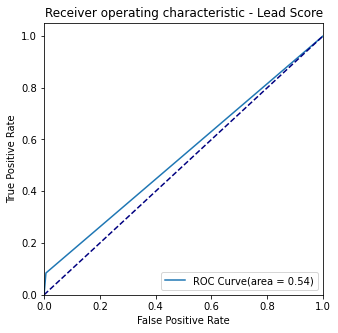

In [122]:
# Predict using probability of 0.5
y_train_pred_final_2 = predict(lr_model_2, X_train_sm_2, y_train_2); print()
_ = evaluate_classification_model("Logistic Regression - TRAIN - 0.5 cut-off", features_2, y_train_pred_final_2['Actual'], y_train_pred_final_2['Predicted'])

     prob  accuracy     sensi     speci
0.0   0.0  0.079914  1.000000  0.000000
0.1   0.1  0.793214  0.779778  0.794381
0.2   0.2  0.901261  0.548968  0.931859
0.3   0.3  0.918183  0.286395  0.973056
0.4   0.4  0.920763  0.141874  0.988413
0.5   0.5  0.920721  0.084172  0.993379
0.6   0.6  0.920086  0.041292  0.996414
0.7   0.7  0.920932  0.028587  0.998437
0.8   0.8  0.920763  0.017999  0.999172
0.9   0.9  0.920298  0.007941  0.999540


<Figure size 720x720 with 0 Axes>

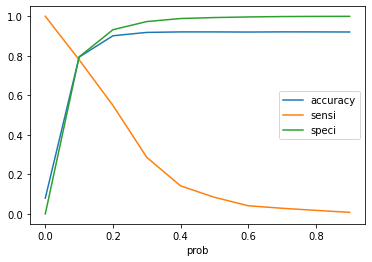

,Actual,Prob,ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
3239,0,0.014161,3239,0,1,0,0,0,0,0,0,0,0,0
1834,0,0.076974,1834,0,1,0,0,0,0,0,0,0,0,0
17891,0,0.006779,17891,0,1,0,0,0,0,0,0,0,0,0
26061,0,0.017486,26061,0,1,0,0,0,0,0,0,0,0,0
3091,0,0.208921,3091,0,1,1,1,0,0,0,0,0,0,0


In [123]:
predAndEvaluateForVariousCutoffs(y_train_pred_final_2)

Logistic Regression - TRAIN - Optimum cut-off Confusion Matrix:
TP: 1473, TN: 17277, FP:4472, FN:416
[[17277  4472]
 [  416  1473]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     21749
           1       0.25      0.78      0.38      1889

    accuracy                           0.79     23638
   macro avg       0.61      0.79      0.63     23638
weighted avg       0.92      0.79      0.84     23638

Accuracy: % 79.32 Sensitivity: 77.98% Specificity: 79.44% Precision: 24.78% Recall: 77.98% FPR: 20.56% PPV: 24.78%


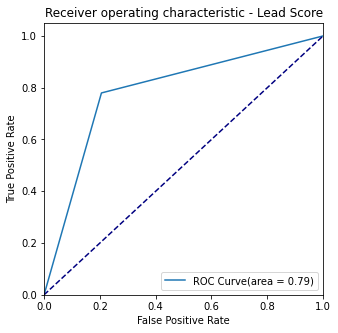

In [124]:
OPTIMUM_CUTOFF = 0.1
# Predict the class using the optinal cut-off
_ = evaluate_classification_model("Logistic Regression - TRAIN - Optimum cut-off", features_2, y_train_pred_final_2['Actual'], y_train_pred_final_2[OPTIMUM_CUTOFF])

#### Test dataset

In [125]:
X_test_2 = X_test_2[features_2]
X_test_2.head()

,arpu_78,offnet_mou_8,total_rech_num_7,sachet_2g_8,sep_vbc_3g,roam_ic_mou_6,spl_ic_mou_8,arpu_6,monthly_3g_8,monthly_2g_8,onnet_mou_8,last_day_rch_amt_8,std_ic_mou_6,std_og_mou_8
8602,0.477909,0.094598,0.326087,0.0,0.000000,0.005736,0.0,0.023975,0.0,0.0,0.032069,0.002248,0.004861,0.049080
23119,0.493076,0.045537,0.072464,0.0,0.000000,0.000000,0.0,0.055221,0.0,0.0,0.049012,0.029220,0.000339,0.000000
5142,0.469291,0.000082,0.159420,0.0,0.000000,0.000000,0.0,0.026274,0.0,0.0,0.000000,0.000000,0.001947,0.000000
105,0.482535,0.028449,0.072464,0.0,0.013118,0.000000,0.0,0.039248,0.0,0.2,0.001057,0.011238,0.000000,0.000476
11349,0.473097,0.026812,0.079710,0.0,0.000000,0.000000,0.0,0.031569,0.0,0.0,0.009616,0.029220,0.002123,0.000199


15 ['const', 'arpu_78', 'offnet_mou_8', 'total_rech_num_7', 'sachet_2g_8', 'sep_vbc_3g', 'roam_ic_mou_6', 'spl_ic_mou_8', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'onnet_mou_8', 'last_day_rch_amt_8', 'std_ic_mou_6', 'std_og_mou_8']
       Actual      Prob     ID  Predicted
8602        0  0.053214   8602          0
23119       0  0.025993  23119          0
5142        0  0.248431   5142          1
105         0  0.011929    105          0
11349       0  0.080267  11349          0
Logistic Regression - TEST Confusion Matrix:
TP: 373, TN: 4307, FP:1131, FN:99
[[4307 1131]
 [  99  373]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      5438
           1       0.25      0.79      0.38       472

    accuracy                           0.79      5910
   macro avg       0.61      0.79      0.63      5910
weighted avg       0.92      0.79      0.84      5910

Accuracy: % 79.19 Sensitivity: 79.03% Specificity: 79.2% Precision: 24.8% Recall: 

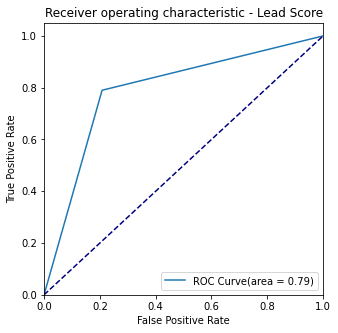

In [126]:
## Predict using the optimum cut-off
X_test_sm_2 = sm.add_constant(X_test_2)
print(len(X_test_sm_2.columns.tolist()), X_test_sm_2.columns.tolist())
y_test_pred_final_2 =  predict(lr_model_2, X_test_sm_2, y_test_2, OPTIMUM_CUTOFF)
_ = evaluate_classification_model("Logistic Regression - TEST", features_2, y_test_pred_final_2['Actual'], y_test_pred_final_2['Predicted'])

In [127]:
print(len(features_1), features_2)
print(len(features_2), features_2)

11 ['arpu_78', 'offnet_mou_8', 'total_rech_num_7', 'sachet_2g_8', 'sep_vbc_3g', 'roam_ic_mou_6', 'spl_ic_mou_8', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'onnet_mou_8', 'last_day_rch_amt_8', 'std_ic_mou_6', 'std_og_mou_8']
14 ['arpu_78', 'offnet_mou_8', 'total_rech_num_7', 'sachet_2g_8', 'sep_vbc_3g', 'roam_ic_mou_6', 'spl_ic_mou_8', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'onnet_mou_8', 'last_day_rch_amt_8', 'std_ic_mou_6', 'std_og_mou_8']


## Decision Tree - 1

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

from graphviz import Source
def get_dt_graph(dt_classifier, X):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True, feature_names=X.columns, class_names=['Not Churned', 'Churned'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"20,50!"')
    return graph.create_png()

In [129]:
X_train_3 = X_train.copy(); y_train_3 = y_train.copy()
X_test_3  = X_test.copy();  y_test_3  = y_test.copy()

In [130]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_3, y_train_3)

DecisionTreeClassifier(max_depth=3)

In [131]:
# Get the feature importances
df_fi = pd.DataFrame({  "variables": X_train_3.columns.to_list(),"feature importance": dt.feature_importances_})
features_3 = df_fi.sort_values(by='feature importance', ascending=False).head()
print(features_3)
features_3 = features_3['variables'].to_list()
print(features_3)

              variables  feature importance
139         total_mou_8            0.752003
16         total_mou_78            0.073940
116  last_day_rch_amt_8            0.059618
63             vol_mb_8            0.057796
112        loc_ic_mou_8            0.029040
['total_mou_8', 'total_mou_78', 'last_day_rch_amt_8', 'vol_mb_8', 'loc_ic_mou_8']


Decision Tree - TRAIN Confusion Matrix:
TP: 865, TN: 21389, FP:360, FN:1024
[[21389   360]
 [ 1024   865]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     21749
           1       0.71      0.46      0.56      1889

    accuracy                           0.94     23638
   macro avg       0.83      0.72      0.76     23638
weighted avg       0.93      0.94      0.94     23638

Accuracy: % 94.15 Sensitivity: 45.79% Specificity: 98.34% Precision: 70.61% Recall: 45.79% FPR: 1.66% PPV: 70.61%


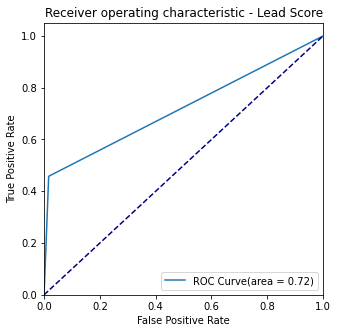

Decision Tree - TEST Confusion Matrix:
TP: 218, TN: 5361, FP:77, FN:254
[[5361   77]
 [ 254  218]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5438
           1       0.74      0.46      0.57       472

    accuracy                           0.94      5910
   macro avg       0.85      0.72      0.77      5910
weighted avg       0.94      0.94      0.94      5910

Accuracy: % 94.4 Sensitivity: 46.19% Specificity: 98.58% Precision: 73.9% Recall: 46.19% FPR: 1.42% PPV: 73.9%


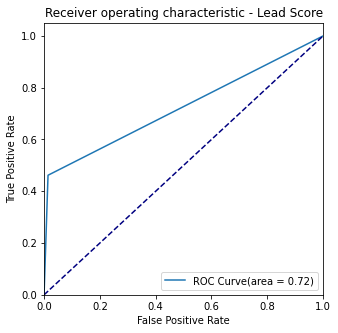

In [132]:
y_train_predicted_3 = dt.predict(X_train_3)
_ = evaluate_classification_model('Decision Tree - TRAIN', features_3, y_train_3, y_train_predicted_3)

y_test_predicted_3  = dt.predict(X_test_3)
_ = evaluate_classification_model('Decision Tree - TEST', features_3, y_test_3, y_test_predicted_3)

In [133]:
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
139,total_mou_8,0.752003
16,total_mou_78,0.073940
116,last_day_rch_amt_8,0.059618
63,vol_mb_8,0.057796
112,loc_ic_mou_8,0.029040


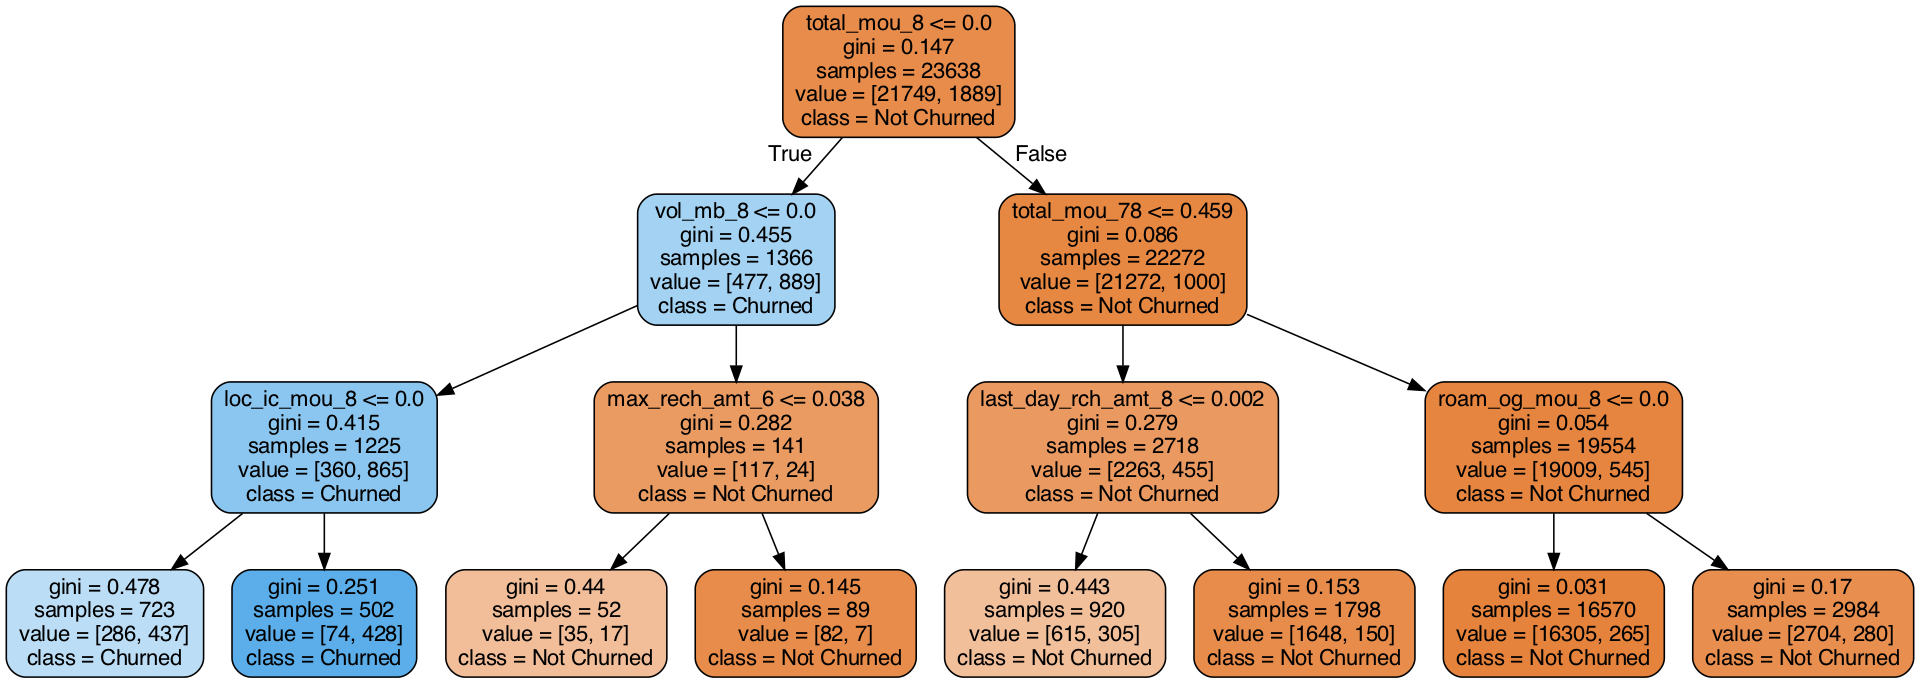

In [134]:
Image(get_dt_graph(dt, X_train_3))

## Decision Tree with Hyperparameter Tuning

In [135]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 4], #5, 10], #If 5 and 10 are included, the best estimator has depth of 10 and the interpretation of the model was difficult. So using only the values of 2,3 4
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [136]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [137]:
X_train_4 = X_train.copy(); y_train_4 = y_train.copy()
X_test_4  = X_test.copy();  y_test_4  = y_test.copy()

In [138]:
%%time
grid_search.fit(X_train_4, y_train_4)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: user 1.38 s, sys: 225 ms, total: 1.61 s
Wall time: 10.5 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [139]:
df_score = pd.DataFrame(grid_search.cv_results_)
df_score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.716631,0.007359,0.012951,0.001773,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3
1,0.718892,0.009011,0.012076,0.000385,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3
2,0.586420,0.064986,0.012502,0.002558,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3
3,0.549691,0.006089,0.010395,0.000838,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3
4,0.452201,0.009650,0.008677,0.000180,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3


In [140]:
df_score.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
9,0.713119,0.008865,0.009809,0.000784,gini,3,100,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.941286,0.940102,0.94043,0.942122,0.940985,0.000786,1
14,0.965113,0.003076,0.010175,0.000727,gini,4,100,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.941286,0.939594,0.94043,0.942291,0.940900,0.001001,2
0,0.716631,0.007359,0.012951,0.001773,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3
1,0.718892,0.009011,0.012076,0.000385,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3
2,0.586420,0.064986,0.012502,0.002558,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.941286,0.939255,0.94043,0.941445,0.940604,0.000869,3


In [141]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=3, min_samples_leaf=100)

In [142]:
# Get the feature importances
df_fi = pd.DataFrame({"variables": X_train_4.columns.to_list(),"feature importance": dt_best.feature_importances_})
features_4 = df_fi.sort_values(by='feature importance', ascending=False).head(); print(features_4)
features_4 = features_4['variables'].tolist(); print(features_4)

              variables  feature importance
139         total_mou_8            0.754432
16         total_mou_78            0.074178
116  last_day_rch_amt_8            0.059810
63             vol_mb_8            0.057983
112        loc_ic_mou_8            0.029134
['total_mou_8', 'total_mou_78', 'last_day_rch_amt_8', 'vol_mb_8', 'loc_ic_mou_8']


Decision Tree - HPT - TRAIN Confusion Matrix:
TP: 865, TN: 21389, FP:360, FN:1024
[[21389   360]
 [ 1024   865]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     21749
           1       0.71      0.46      0.56      1889

    accuracy                           0.94     23638
   macro avg       0.83      0.72      0.76     23638
weighted avg       0.93      0.94      0.94     23638

Accuracy: % 94.15 Sensitivity: 45.79% Specificity: 98.34% Precision: 70.61% Recall: 45.79% FPR: 1.66% PPV: 70.61%


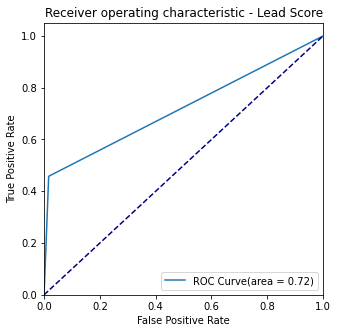

Decision Tree - HPT - TEST Confusion Matrix:
TP: 218, TN: 5361, FP:77, FN:254
[[5361   77]
 [ 254  218]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5438
           1       0.74      0.46      0.57       472

    accuracy                           0.94      5910
   macro avg       0.85      0.72      0.77      5910
weighted avg       0.94      0.94      0.94      5910

Accuracy: % 94.4 Sensitivity: 46.19% Specificity: 98.58% Precision: 73.9% Recall: 46.19% FPR: 1.42% PPV: 73.9%


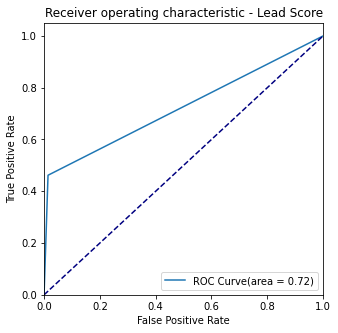

In [143]:
y_train_predicted_4 = dt_best.predict(X_train_4)
metrics_ = evaluate_classification_model('Decision Tree - HPT - TRAIN', features_4, y_train_4, y_train_predicted_4)

y_test_predicted_4  = dt_best.predict(X_test_4)
metrics_ = evaluate_classification_model('Decision Tree - HPT - TEST', features_4, y_test_4, y_test_predicted_4)

In [144]:
# Get the feature importances
df_fi = pd.DataFrame({"variables": X_train_4.columns.to_list(), "feature importance": dt_best.feature_importances_})
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
139,total_mou_8,0.754432
16,total_mou_78,0.074178
116,last_day_rch_amt_8,0.059810
63,vol_mb_8,0.057983
112,loc_ic_mou_8,0.029134


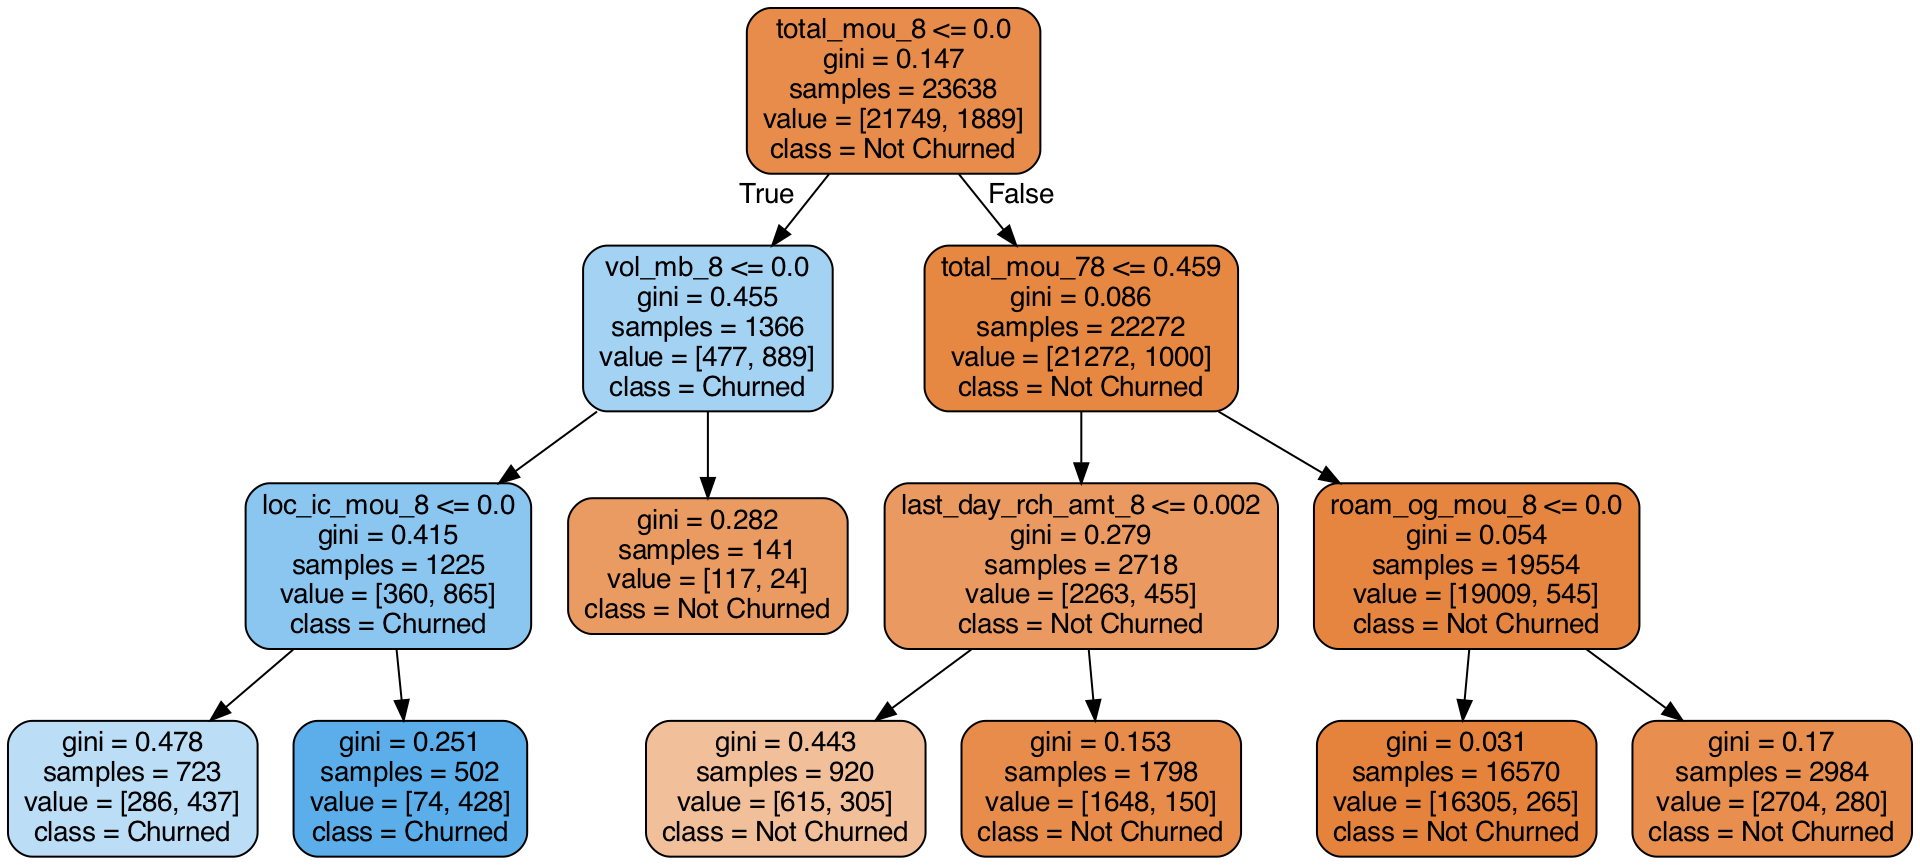

In [145]:
Image(get_dt_graph(dt_best, X_train_4))

## Summary

In [146]:
DF_SUMMARY

,Category,Features,Accuracy,Sensitivity,Specificity,Precision,Recall,AUC,Num Features
0,Logistic Regression - TRAIN - o.5 cut-off,"[arpu_78, total_ic_mou_8, vol_mb_8, spl_ic_mou...",92.54,15.88,99.20,63.16,15.88,57.54,11.0
1,Logistic Regression - TRAIN - Optimum cut-off,"[arpu_78, total_ic_mou_8, vol_mb_8, spl_ic_mou...",82.49,78.93,82.80,28.50,78.93,80.87,11.0
2,Logistic Regression - TEST,"[arpu_78, total_ic_mou_8, vol_mb_8, spl_ic_mou...",83.15,79.45,83.47,29.43,79.45,81.46,11.0
3,Logistic Regression - TRAIN - 0.5 cut-off,"[arpu_78, offnet_mou_8, total_rech_num_7, sach...",92.07,8.42,99.34,52.48,8.42,53.88,14.0
4,Logistic Regression - TRAIN - Optimum cut-off,"[arpu_78, offnet_mou_8, total_rech_num_7, sach...",79.32,77.98,79.44,24.78,77.98,78.71,14.0
5,Logistic Regression - TEST,"[arpu_78, offnet_mou_8, total_rech_num_7, sach...",79.19,79.03,79.20,24.80,79.03,79.11,14.0
6,Decision Tree - TRAIN,"[total_mou_8, total_mou_78, last_day_rch_amt_8...",94.15,45.79,98.34,70.61,45.79,72.07,5.0
7,Decision Tree - TEST,"[total_mou_8, total_mou_78, last_day_rch_amt_8...",94.40,46.19,98.58,73.90,46.19,72.39,5.0
8,Decision Tree - HPT - TRAIN,"[total_mou_8, total_mou_78, last_day_rch_amt_8...",94.15,45.79,98.34,70.61,45.79,72.07,5.0
9,Decision Tree - HPT - TEST,"[total_mou_8, total_mou_78, last_day_rch_amt_8...",94.40,46.19,98.58,73.90,46.19,72.39,5.0


In [147]:
print(features_1)
print(features_2)
print(features_3)
print(features_4)

['arpu_78', 'total_ic_mou_8', 'vol_mb_8', 'spl_ic_mou_8', 'roam_og_mou_7', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'std_og_mou_8']
['arpu_78', 'offnet_mou_8', 'total_rech_num_7', 'sachet_2g_8', 'sep_vbc_3g', 'roam_ic_mou_6', 'spl_ic_mou_8', 'arpu_6', 'monthly_3g_8', 'monthly_2g_8', 'onnet_mou_8', 'last_day_rch_amt_8', 'std_ic_mou_6', 'std_og_mou_8']
['total_mou_8', 'total_mou_78', 'last_day_rch_amt_8', 'vol_mb_8', 'loc_ic_mou_8']
['total_mou_8', 'total_mou_78', 'last_day_rch_amt_8', 'vol_mb_8', 'loc_ic_mou_8']


# Recommend strategies to manage customer churn